## **1. Getting the data and analyzing its structure**


In [1]:
#Include Library to ignore unnecessary warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import numpy as np
df = pd.read_csv('titanic.csv') #Read the csv file
df.shape #Get the shape of the dataframe

(891, 12)

In [3]:
df.info() #Get the info of the dataframe


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [4]:
#Using df.sample() to get a random sample of rows from the dataframe
df.sample(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
771,772,0,3,"Jensen, Mr. Niels Peder",male,48.0,0,0,350047,7.8542,NaN,S
675,676,0,3,"Edvardsson, Mr. Gustaf Hjalmar",male,18.0,0,0,349912,7.7750,NaN,S
754,755,1,2,"Herman, Mrs. Samuel (Jane Laver)",female,48.0,1,2,220845,65.0000,NaN,S
247,248,1,2,"Hamalainen, Mrs. William (Anna)",female,24.0,0,2,250649,14.5000,NaN,S
385,386,0,2,"Davies, Mr. Charles Henry",male,18.0,0,0,S.O.C. 14879,73.5000,NaN,S


## **2. Cleaning The Data**

#### **Handling Nan Values**

In [5]:
df.isnull().sum() #Get the sum of missing values for each column in the dataframe 

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

- Now As we can see that the column 'Cabin' have too many missing values so its not useful in the analysis of this data so we can Drop this column

- Also The column PassengerId does not help in the analysis of the dataset either so we can drop it too

In [6]:
df.drop("Cabin", axis=1, inplace=True) 
df.drop("PassengerId", axis=1, inplace=True) 
df

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S
...,...,...,...,...,...,...,...,...,...,...
886,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,S
887,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,S
888,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,S
889,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C


- We Handle The remaining Missing Values using **Imputation**

- The column Age have 177 missing values. So we fill these values with the median Of the non negative values.

- The Column Embarked is a Categorical Column so it makes sense to fill The NaN values with the mode of the remaining Values

In [7]:
df['Age'].fillna(df['Age'].median(), inplace=True)
df['Embarked'].fillna(df['Embarked'].mode()[0], inplace=True)

#### **Handling Duplicate Values**

In [8]:
df.duplicated().sum() #Get the sum of duplicated rows in the dataframe


np.int64(0)

- As we can see the dataset Does not have Any Duplicate Value we do no need to worry about them

#### **Outlier Detection And Removal**

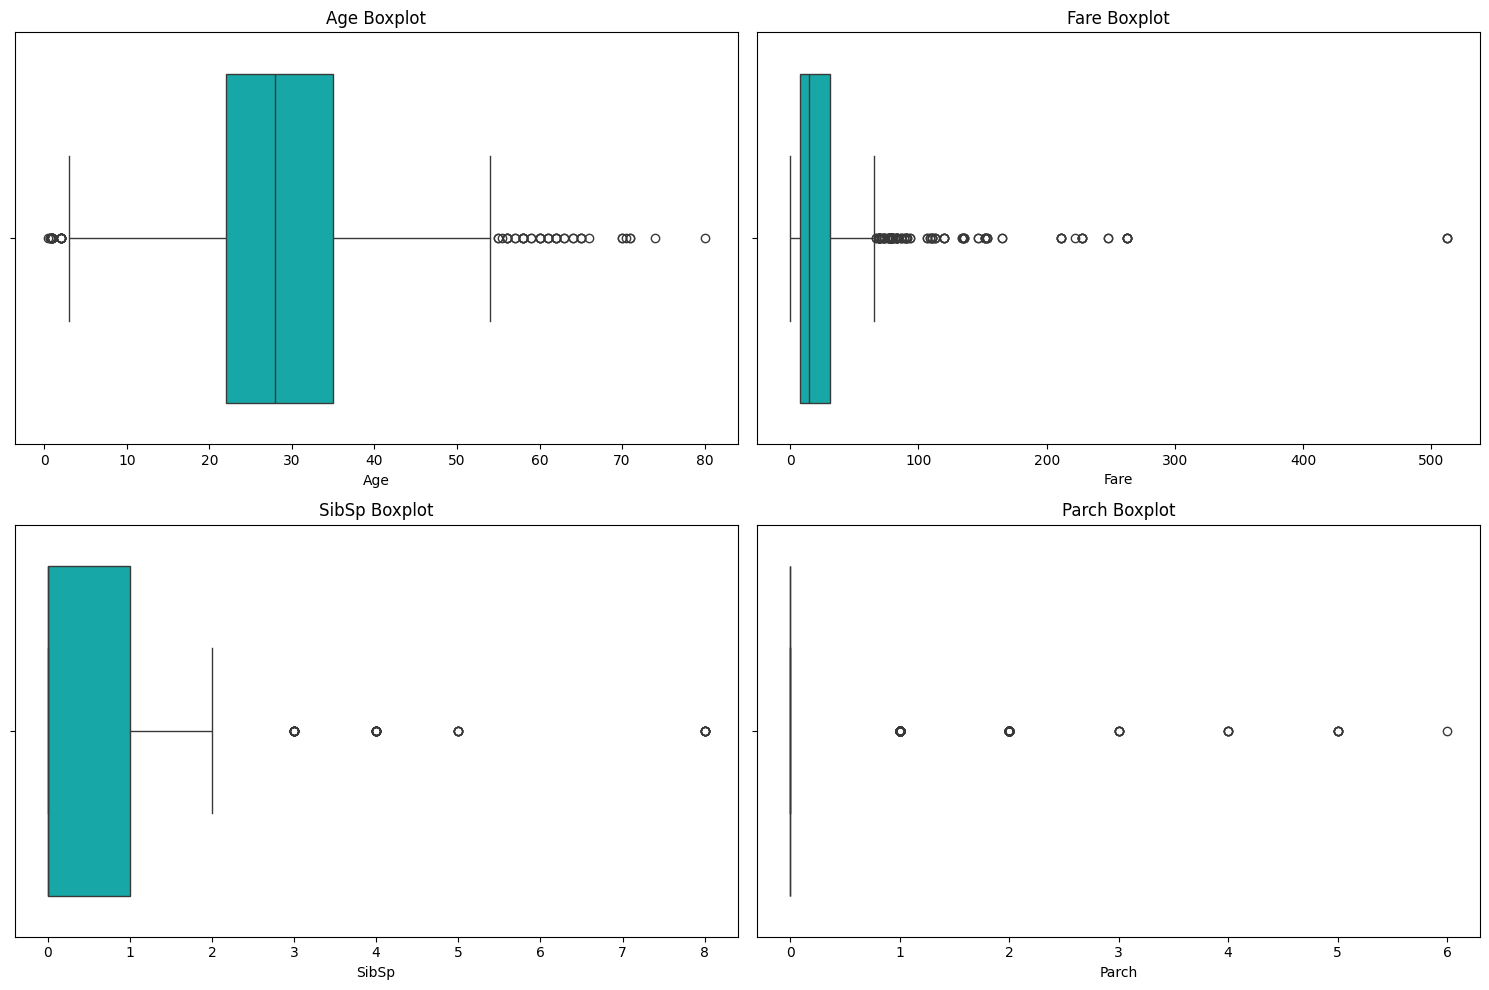

In [9]:
#Making Boxplot for Detection of Outliers
import seaborn as sns
import matplotlib.pyplot as plt
numerical_cols = ["Age", "Fare", "SibSp", "Parch"] #List of numerical columns
plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(2, (len(numerical_cols) + 1) // 2, i)
    sns.boxplot(x=df[col], color='c')
    plt.title(f"{col} Boxplot")
    plt.xlabel(col, fontsize=10)

plt.tight_layout()
plt.show()


As we can see from the Boxplots that there are a lot of Outliers in Our Numerical Data

In [10]:
skew1 = df['Age'].skew()
skew2 = df['Fare'].skew()
print(f"Skewness of Age: {skew1}")
print(f"Skewness of Fare: {skew2}")

Skewness of Age: 0.5102446555756495
Skewness of Fare: 4.787316519674893


- The **Skewness** of the column 'Fare' is high so we can use the **IQR** method to remove outliers from it
- As the **Skewness** of 'Age' in the dataset is low, the dataset is almost **Normally distributed**, So using **IQR** for removing outliers from age may remove a lot of rows with valid ages..
- So we use **Z-Score** Method to remove the Outliers Instead.

- For Removing Outliers from The 'Sibsp' and 'Parch' Column, We use a Threshold value as the values in this columns are not continuous data but are Discrete Count Data, So Using a Threshold Value is Better.

In [11]:
#Removing outliers from column 'Fare' using IQR 

Q1 = df['Fare'].quantile(0.25) #Get the first quartile(25th percentile)
Q3 = df['Fare'].quantile(0.75) #Get the third quartile(75th percentile)
IQR = Q3 - Q1 #Get the Interquartile Range
lower_bound = Q1 - 1.5 * IQR #Get the lower bound
upper_bound = Q3 + 1.5 * IQR #Get the upper bound
outliers = df[(df['Fare'] < lower_bound) | (df['Fare'] > upper_bound)].shape[0]
df = df[~((df['Fare'] < (lower_bound)) |(df['Fare'] > (upper_bound)))] #Remove outliers
print("The Number of Outliers in 'Fare' Column:", outliers)
print("The Shape of the DataFrame after Removing Outliers:", df.shape)
df.shape #Get the shape of the dataframe after removing outliers

The Number of Outliers in 'Fare' Column: 116
The Shape of the DataFrame after Removing Outliers: (775, 10)


(775, 10)

In [12]:
# Removing outliers from column 'Age' using Z-score
from scipy.stats import zscore

# Compute Z-scores for Age column
df["Age_Zscore"] = zscore(df["Age"])

# Filter out rows where |Z-score| > 3
outliers = df[abs(df["Age_Zscore"]) > 3].shape[0]
print("The Number of Outliers in 'Age' Column:", outliers)
df = df[abs(df["Age_Zscore"]) <= 3]

# Drop the temporary Z-score column
df.drop(columns=["Age_Zscore"], inplace=True)

#Removing Outliers from columns 'SibSp' and 'Parch' by setting a threshold 
df["SibSp"] = df["SibSp"].clip(upper=5) # Reasonable max value
df["Parch"] = df["Parch"].clip(upper=5) # Reasonable max value
print("The Shape of the DataFrame after Removing Outliers:", df.shape)
df.shape

The Number of Outliers in 'Age' Column: 6
The Shape of the DataFrame after Removing Outliers: (769, 10)


(769, 10)

#### **Standardizing Categorical Values**

Dropping The **'Names'** and **'Tickets'** column as they do not help in our Analysis of the dataset

In [13]:
df.drop(columns=["Name", "Ticket"], inplace=True)

Converting all text to **lowercase/uppercase** and striping **whitespace** for consistency.

In [14]:

df['Sex'] = df['Sex'].str.lower().str.strip()

**Standardizing Known Values**

In [15]:
df['Sex'] = df['Sex'].replace({'male': 'Male', 'female': 'Female'})

## **2. Univariate Analysis**

#### **Getting the Statistical Information of the Numerical Columns**

In [16]:
#Statistical Analysis of the data 

selected_df = df[numerical_cols]

# Compute summary statistics
summary_stats = selected_df.describe().T  # Transpose for better readability
summary_stats["mode"] = selected_df.mode().iloc[0]  # Mode
summary_stats["variance"] = selected_df.var()  # Variance
summary_stats["skewness"] = selected_df.skew()  # Skewness
summary_stats


,count,mean,std,min,25%,50%,75%,max,mode,variance,skewness
Age,769.0,28.405397,12.219669,0.42,22.0000,28.0,34.0,66.0,28.00,149.320307,0.309475
Fare,769.0,17.778852,13.549928,0.00,7.8958,13.0,26.0,65.0,8.05,183.600557,1.441620
SibSp,769.0,0.440832,0.902512,0.00,0.0000,0.0,1.0,5.0,0.00,0.814528,2.777141
Parch,769.0,0.342003,0.779835,0.00,0.0000,0.0,0.0,5.0,0.00,0.608142,3.019837


#### **Plotting Plots of Categorical Columns**

Frequency Distribution for column Survived :
Survived
0    507
1    262
Name: count, dtype: int64




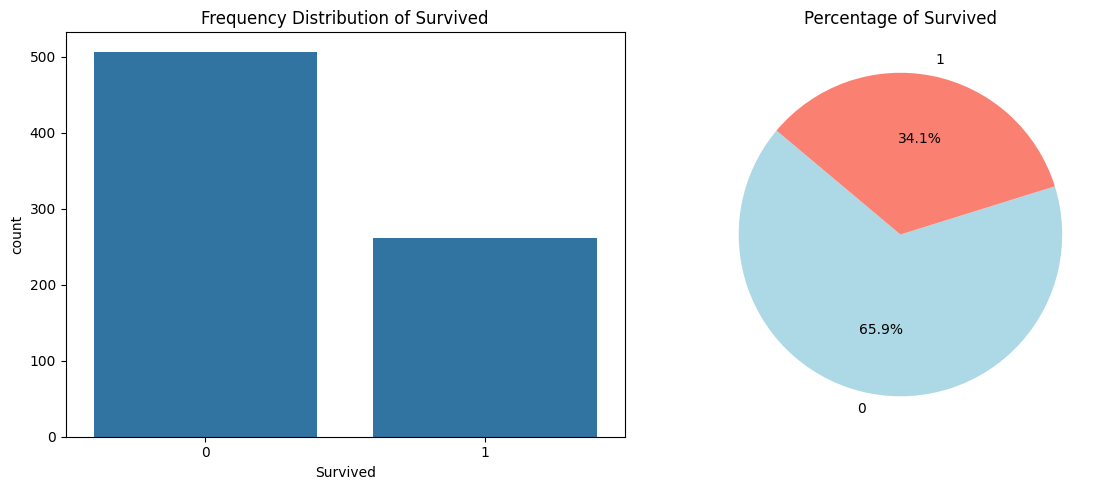

Frequency Distribution for column Pclass :
Pclass
3    482
2    178
1    109
Name: count, dtype: int64




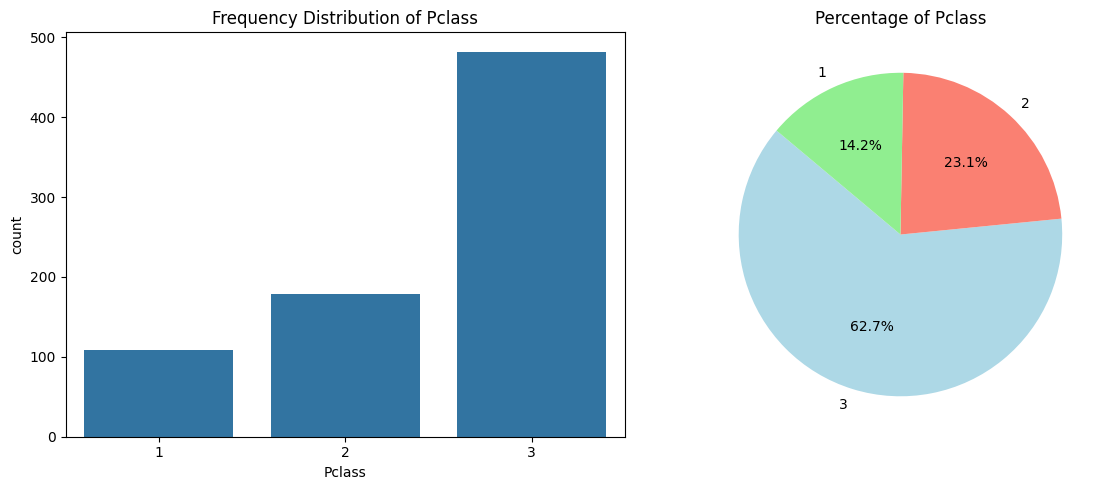

Frequency Distribution for column Embarked :
Embarked
S    581
C    114
Q     74
Name: count, dtype: int64




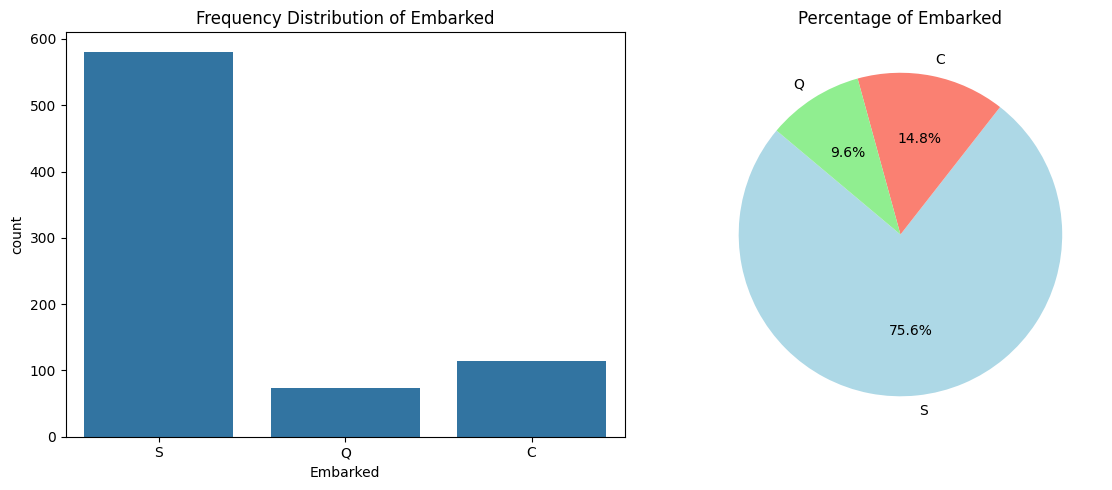

Frequency Distribution for column Sex :
Sex
Male      525
Female    244
Name: count, dtype: int64




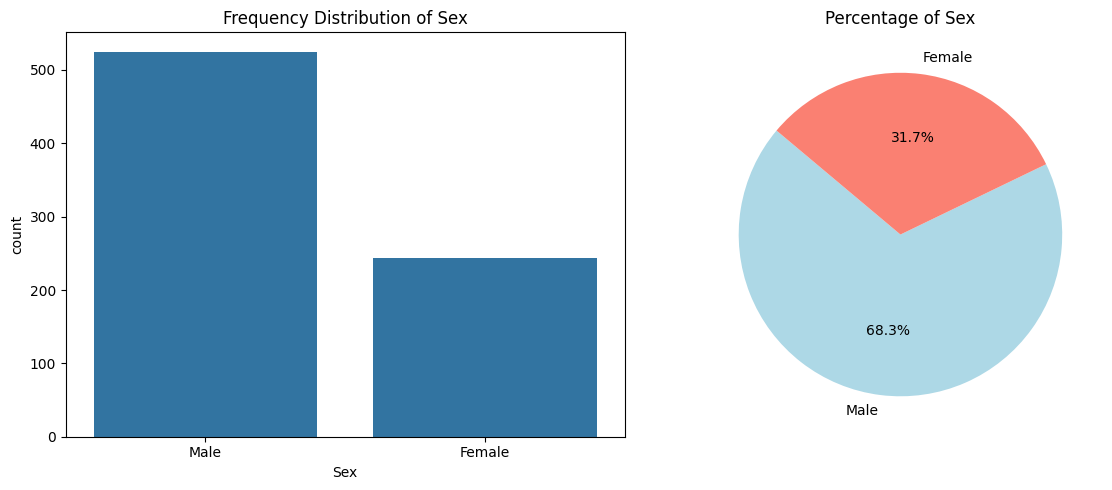

In [ ]:

Categorical_Columns = ["Survived", "Pclass","Embarked","Sex"]
for col in Categorical_Columns:
    # Frequency Distribution
    print("Frequency Distribution for column %s :"%col)
    print(df[col].value_counts())
    print("\n")
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # Two subplots in one row

    # Countplot (Bar Chart)
    sns.countplot(x=df[col], ax=axes[0])
    axes[0].set_title(f"Frequency Distribution of {col}", fontsize=12)

    # Pie Chart
    axes[1].pie(df[col].value_counts(), labels=df[col].value_counts().index, 
                autopct="%1.1f%%", startangle=140, colors=["lightblue", "salmon", "lightgreen", "orange"])
    axes[1].set_title(f"Percentage of {col}", fontsize=12)

    plt.tight_layout()
    plt.show()

**Frequency Distribution Analysis of Categorical Variables in the Titanic Dataset**

The Titanic dataset contains several categorical variables that provide insights into the demographics and survival patterns of passengers. Below is a detailed analysis of the frequency distribution for **Survived, Pclass, Sex, and Embarked** columns.

---

**Survived (Survival Status)**
- Majority **(~61.6%)** of passengers did not survive, while only **38.4% survived**.
- This indicates a **high fatality rate**, likely due to **limited lifeboats** and **chaotic evacuation**.
- The dataset is imbalanced, with significantly more passengers not surviving.

---

**Pclass (Passenger Class)**
- 3rd class had the most passengers, followed by 1st class, and 2nd class had the least.
- **1st class passengers had better survival chances** probably due to **closer proximity to lifeboats** and **better access to safety measures**.
- **3rd class passengers had the worst survival rates**, likely due to their location in lower decks.

---

**Sex (Gender Distribution)**
- **Around 65% of passengers were male**, and **35% were female**.
- Despite fewer women, **they had a higher survival rate** probably due to the "Women and Children First" policy.
- **Males had a significantly lower survival rate**, suggesting gender played a major role in survival.

---

**Embarked (Port of Embarkation)**
- **Southampton (S)** had the highest number of passengers, followed by **Cherbourg (C)** and **Queenstown (Q)**.
- **Cherbourg** had more 1st class passengers, correlating with higher survival rates.
- **Queenstown** had mostly 3rd class passengers, which may explain lower survival rates.

---

**Key Takeaways**
- **Survival rate was low**, with most passengers perishing.
- **Pclass** and **Sex** significantly influenced survival, with **1st class passengers and women surviving more**.
- **Southampton had the most passengers**, but **Cherbourg passengers had better survival rates**.

This distribution helps in understanding **demographics, survival patterns, and potential factors affecting survival rates**.


#### **Plotting Plots of Numerical Columns**

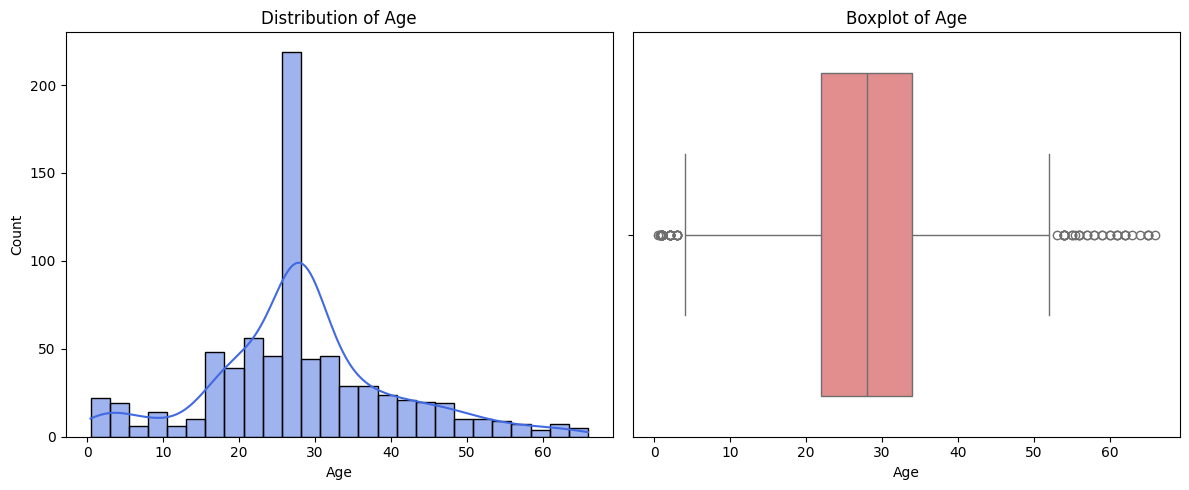

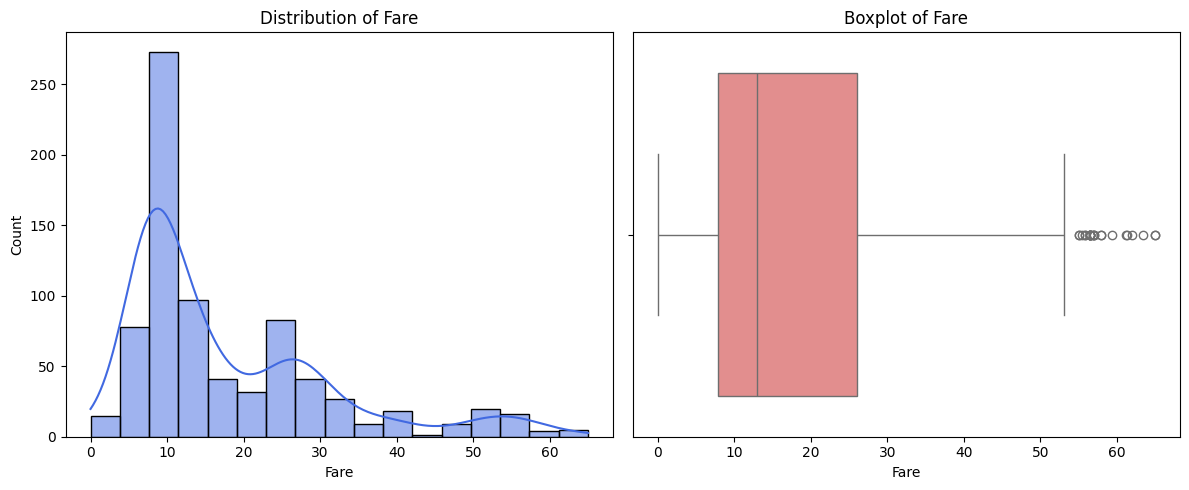

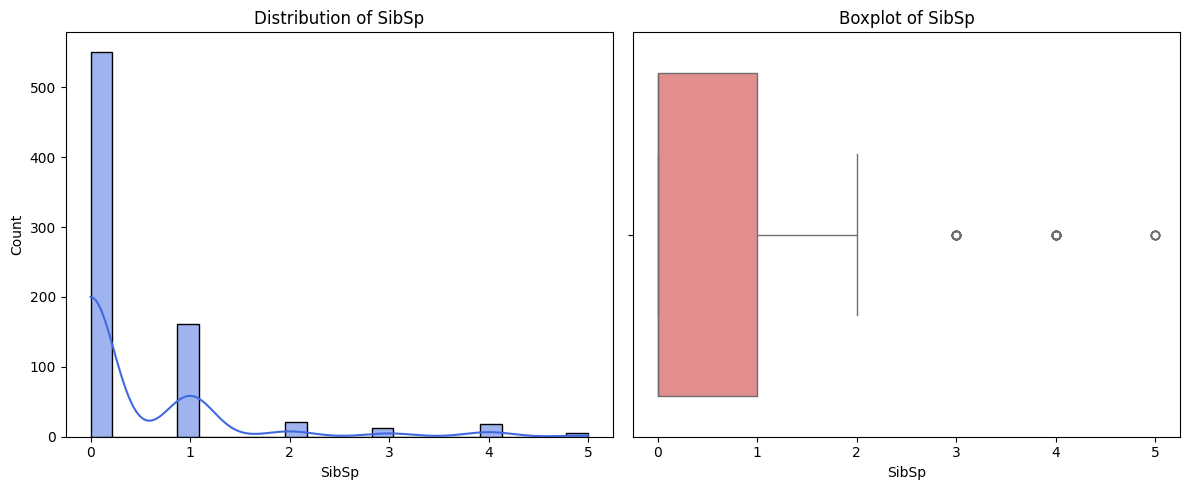

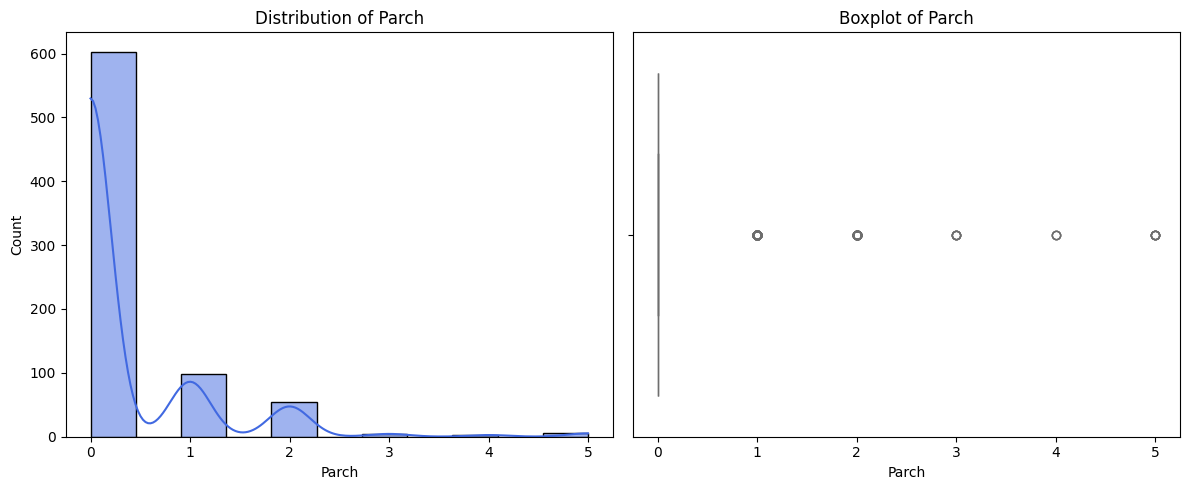

In [18]:

for col in numerical_cols:
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # Two subplots per row

    # Histogram
    sns.histplot(df[col], kde=True, ax=axes[0], color="royalblue")
    axes[0].set_title(f"Distribution of {col}", fontsize=12)

    # Boxplot
    sns.boxplot(x=df[col], ax=axes[1], color="lightcoral")
    axes[1].set_title(f"Boxplot of {col}", fontsize=12)

    # Adjust layout for better spacing
    plt.tight_layout()
    plt.show()

**Analysis of Histograms for Age, Fare, SibSp, and Parch in the Titanic Dataset**

Histograms help us understand the **distribution, skewness, and presence of outliers** in numerical features. Below is the analysis for **Age, Fare, SibSp, and Parch**.

---

**Age Distribution**
- The **age distribution is right-skewed** with a peak between **20-40 years**.
- **Most passengers were young adults**, with fewer children and elderly passengers.
- There are some **outliers for very high ages**, but the majority of passengers were **between 0-80 years**.
- A small **gap in the histogram suggests missing values**, which were imputed.

---

**Fare Distribution**
- **Highly right-skewed**: Most passengers paid **low fares**, while **a few paid extremely high fares**.
- **Majority of fares were below 50**, but a few passengers in **1st class** paid significantly more.
- There are **outliers**, indicating **a wide disparity in ticket prices** due to different classes.

---

**SibSp (Siblings/Spouses Aboard)**
- **Most passengers traveled alone** (SibSp = 0).
- A **few passengers had 1-2 siblings/spouses**, but large family sizes were rare.
- **Higher SibSp values are outliers**, suggesting that **most people traveled in small groups**.

---

**Parch (Parents/Children Aboard)**
- **Majority of passengers (Parch = 0) were traveling without parents or children**.
- **A few had 1-2 family members**, while **large families were rare**.
- Like SibSp, **higher values are outliers**, indicating that **most travelers were not with their parents or children**.

---

**Key Takeaways**
- **Age follows a normal-like distribution** but is **slightly right-skewed**.
- **Fare is highly right-skewed**, showing a **large variation in ticket prices**.
- **SibSp and Parch indicate most passengers traveled alone or in small families**.
- **Outliers are present in all features**, especially in **Fare and Age**.

These insights help in understanding passenger demographics and how family size and ticket class might influence survival.


## **3. Bivariate Analysis**

In [19]:
correlation_matrix = df.corr(numeric_only=True)
print("Correlation Matrix to visualize the relationship between numerical columns:")
print("\n")
print(correlation_matrix)


Correlation Matrix to visualize the relationship between numerical columns:


          Survived    Pclass       Age     SibSp     Parch      Fare
Survived  1.000000 -0.240775 -0.115591 -0.004557  0.099971  0.236344
Pclass   -0.240775  1.000000 -0.344623  0.111690  0.080964 -0.585860
Age      -0.115591 -0.344623  1.000000 -0.338370 -0.206536  0.078689
SibSp    -0.004557  0.111690 -0.338370  1.000000  0.412674  0.374510
Parch     0.099971  0.080964 -0.206536  0.412674  1.000000  0.340652
Fare      0.236344 -0.585860  0.078689  0.374510  0.340652  1.000000


#### **Numerical V/S Numerical**


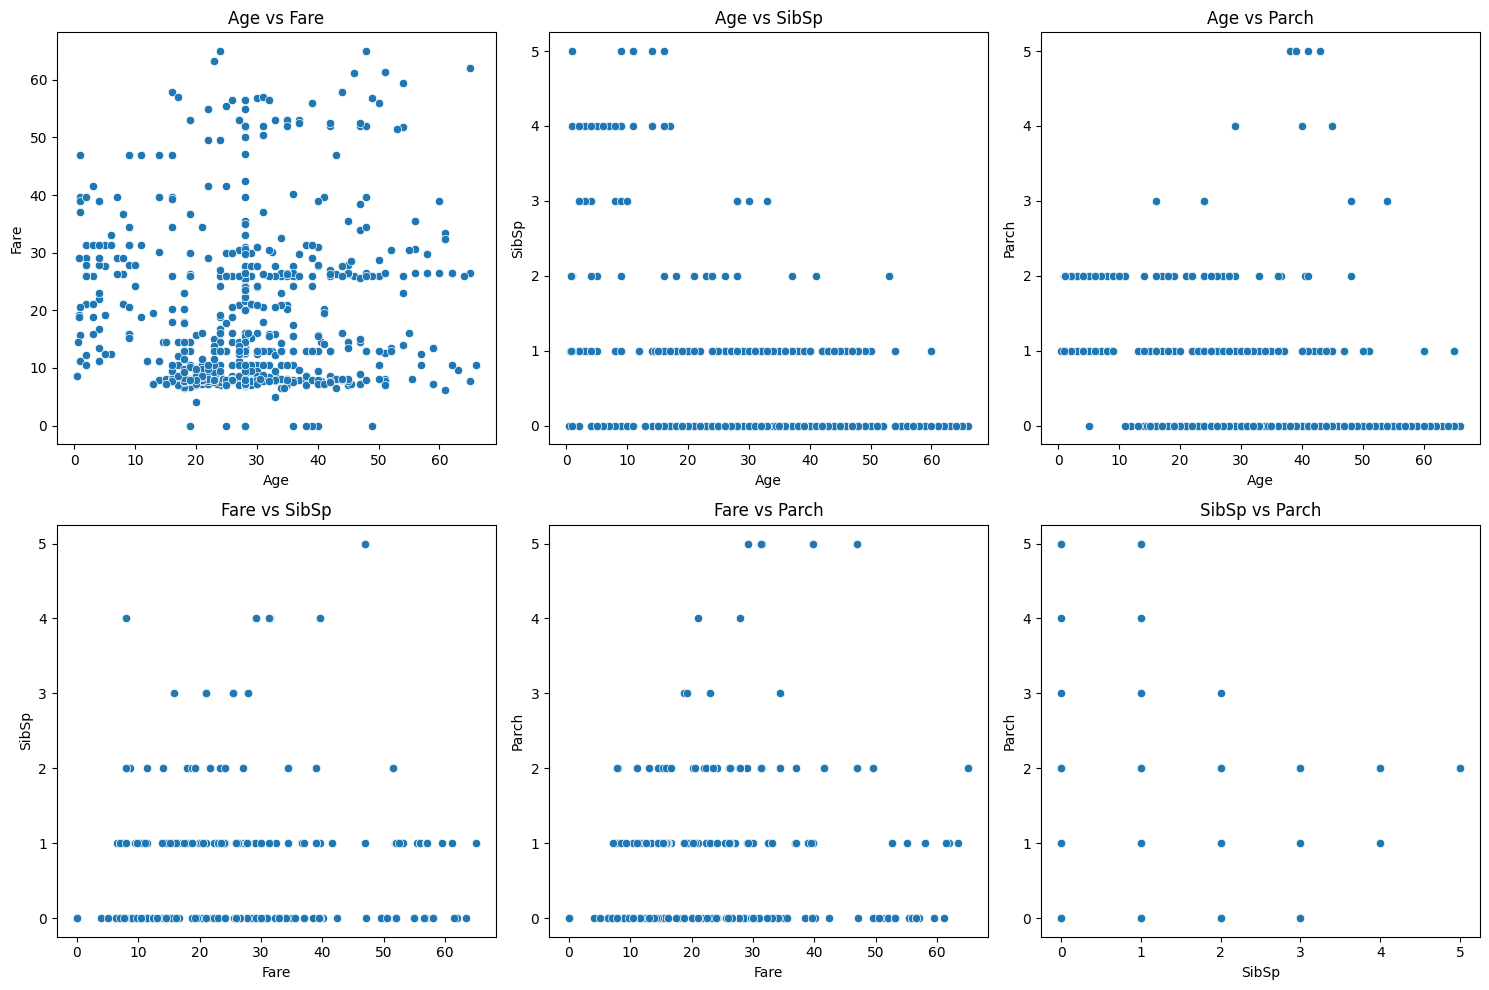

In [20]:
num_pairs = len(numerical_cols) * (len(numerical_cols) - 1) // 2  # Total scatterplots
rows = (num_pairs + 2) // 3  # Adjust rows for better layout

fig, axes = plt.subplots(rows, 3, figsize=(15, 5 * rows))  # 3 columns per row
axes = axes.flatten()  # Flatten the axes array for easy iteration

plot_idx = 0
for i in range(len(numerical_cols)):
    for j in range(i + 1, len(numerical_cols)):
        sns.scatterplot(x=numerical_cols[i], y=numerical_cols[j], data=df, ax=axes[plot_idx])
        axes[plot_idx].set_title(f"{numerical_cols[i]} vs {numerical_cols[j]}")
        plot_idx += 1

# Hide any unused subplots
for k in range(plot_idx, len(axes)):
    fig.delaxes(axes[k])

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()


**Inferences From doing Numerical V/S Numerical Bivariate Analysis**

**Age vs. Fare**
- **No strong correlation** between Age and Fare.
- **Younger passengers** paid both high and low fares.
- **Older passengers** seem to have paid lower fares on average.
---
**Age vs. SibSp**
- Most passengers with **SibSp = 0-2** are spread across all ages.
- **Large family sizes (SibSp > 3) are mostly younger passengers**, likely children traveling with families.
---
**Age vs. Parch**
- Similar to SibSp, **most passengers had Parch = 0**.
- **Children under 10** were more likely to have higher Parch values (traveling with parents).
---
**Fare vs. SibSp & Parch**
- **Higher SibSp/Parch values are linked with lower fares**, suggesting large families were in **lower-class cabins**.
- A few **outliers with high fares and low family sizes**, indicating wealthy solo travelers.

#### **Numerical V/S Categorical**


**Barplot**

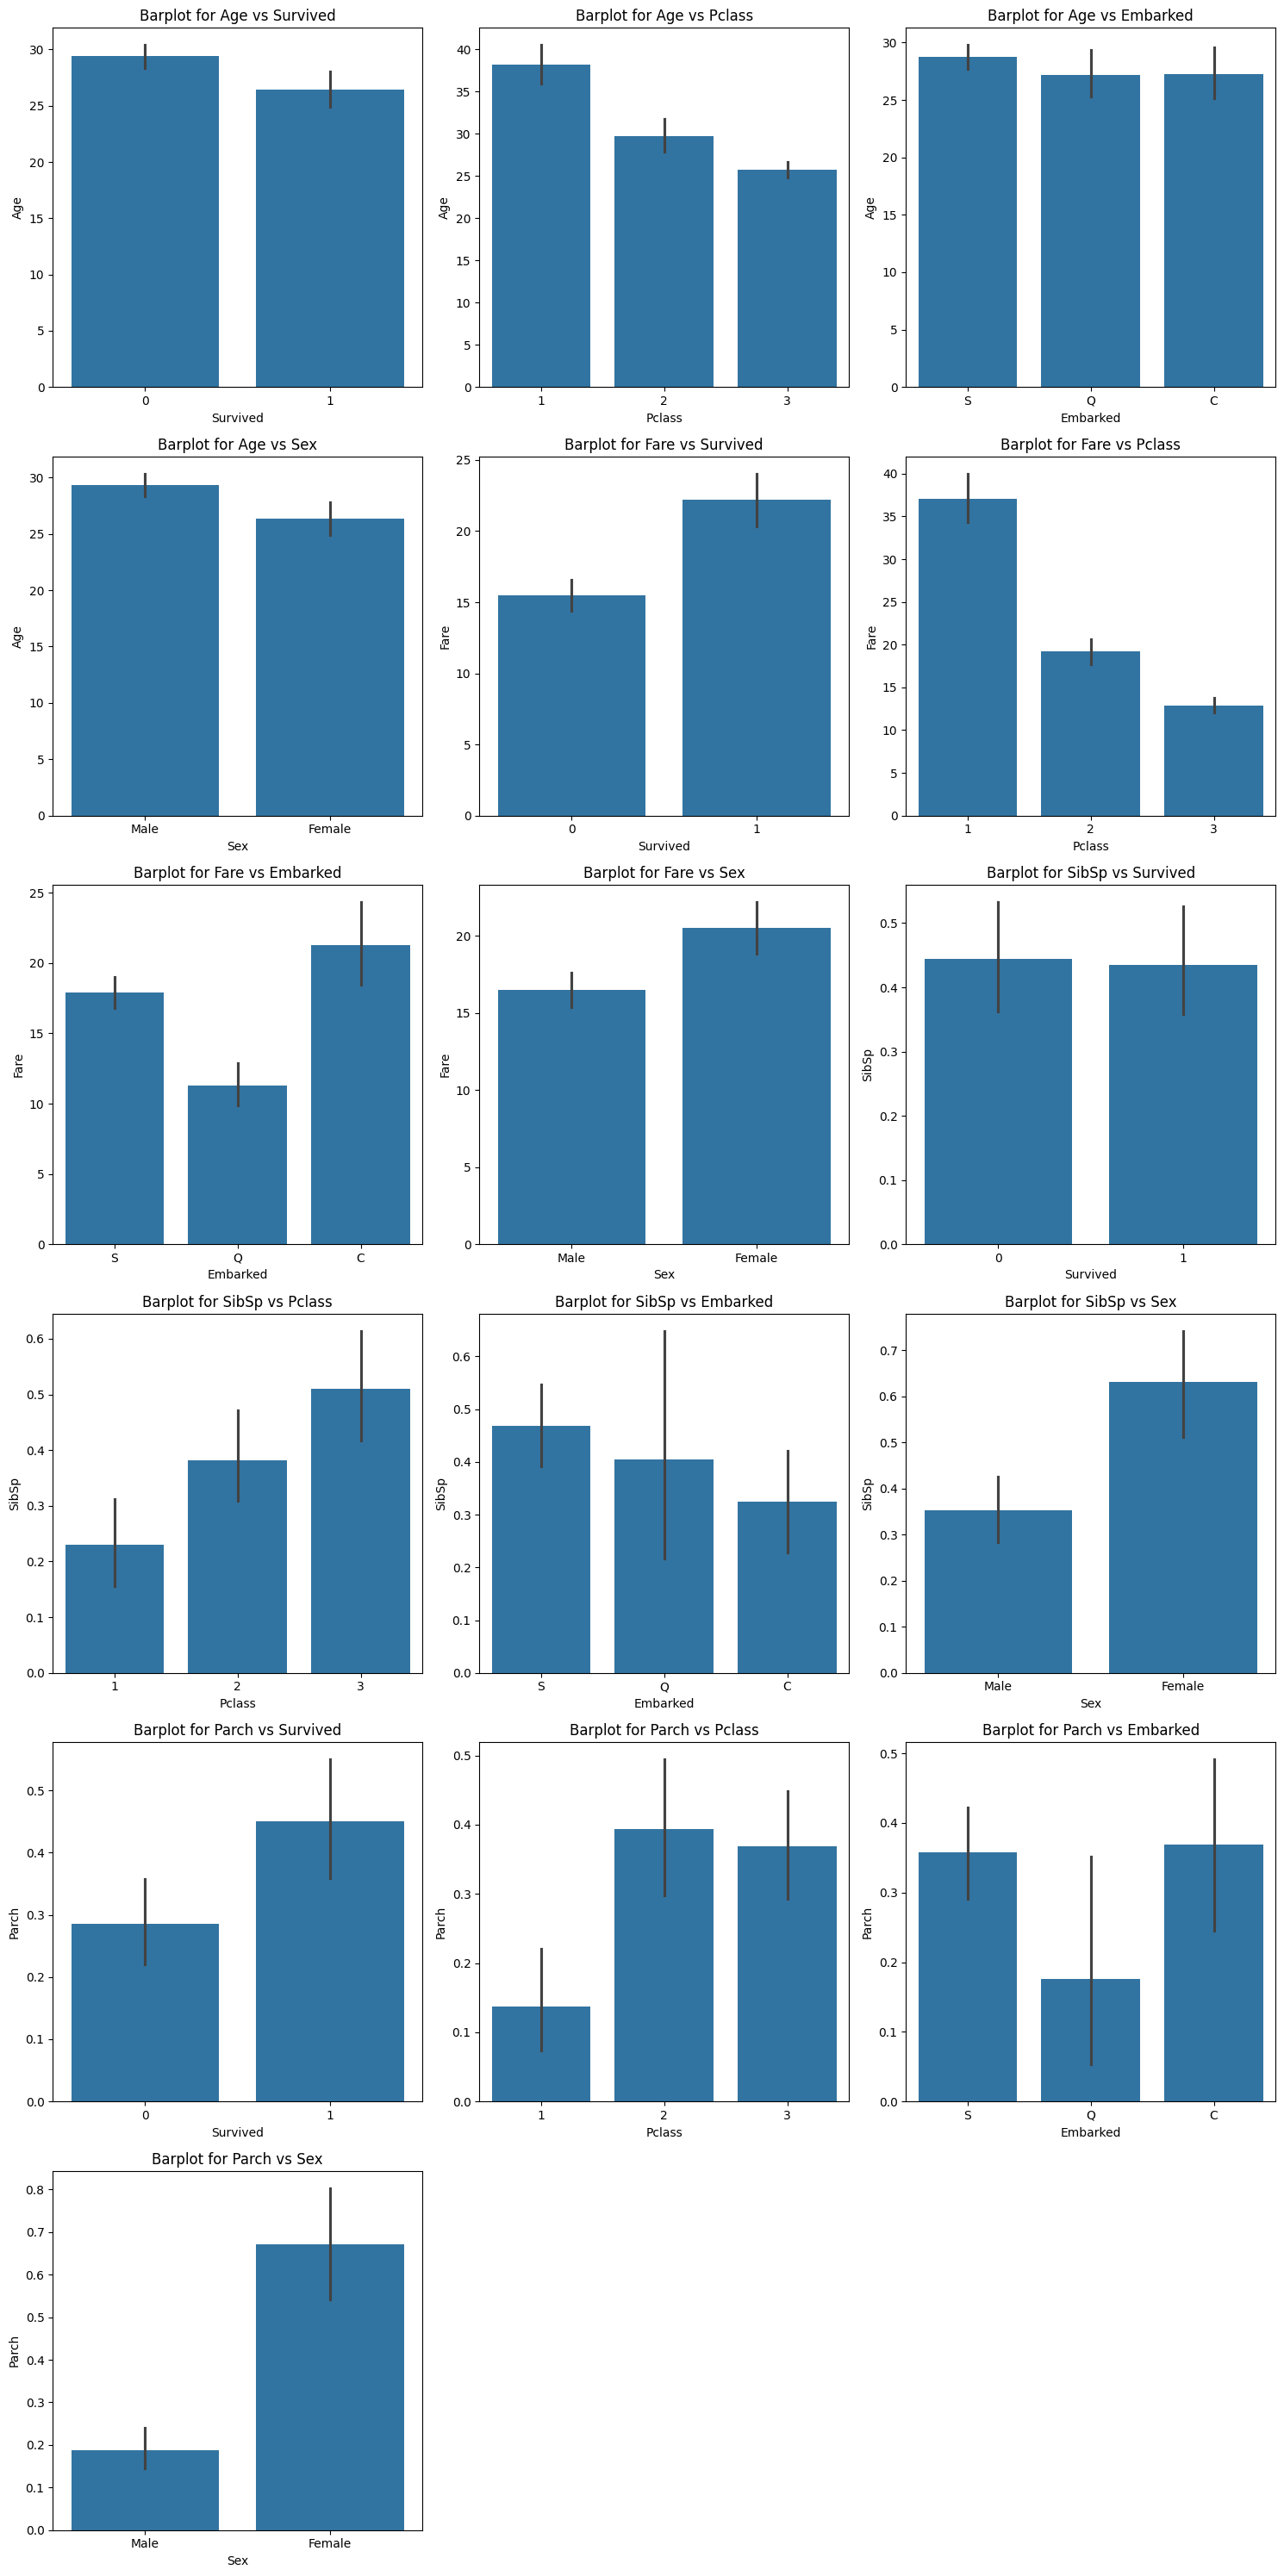

In [21]:
num_pairs = len(numerical_cols) * len(Categorical_Columns)  # Total barplots
rows = (num_pairs + 2) // 3  # Adjust rows for better layout

fig, axes = plt.subplots(rows, 3, figsize=(15, 5 * rows))  # 3 columns per row
axes = axes.flatten()  # Flatten the axes array for easy iteration

plot_idx = 0
for col in numerical_cols:
    for col2 in Categorical_Columns:
        sns.barplot(x=col2, y=col, data=df, ax=axes[plot_idx])
        axes[plot_idx].set_title(f"Barplot for {col} vs {col2}")
        plot_idx += 1

# Hide any unused subplots
for k in range(plot_idx, len(axes)):
    fig.delaxes(axes[k])

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

**Boxplot**


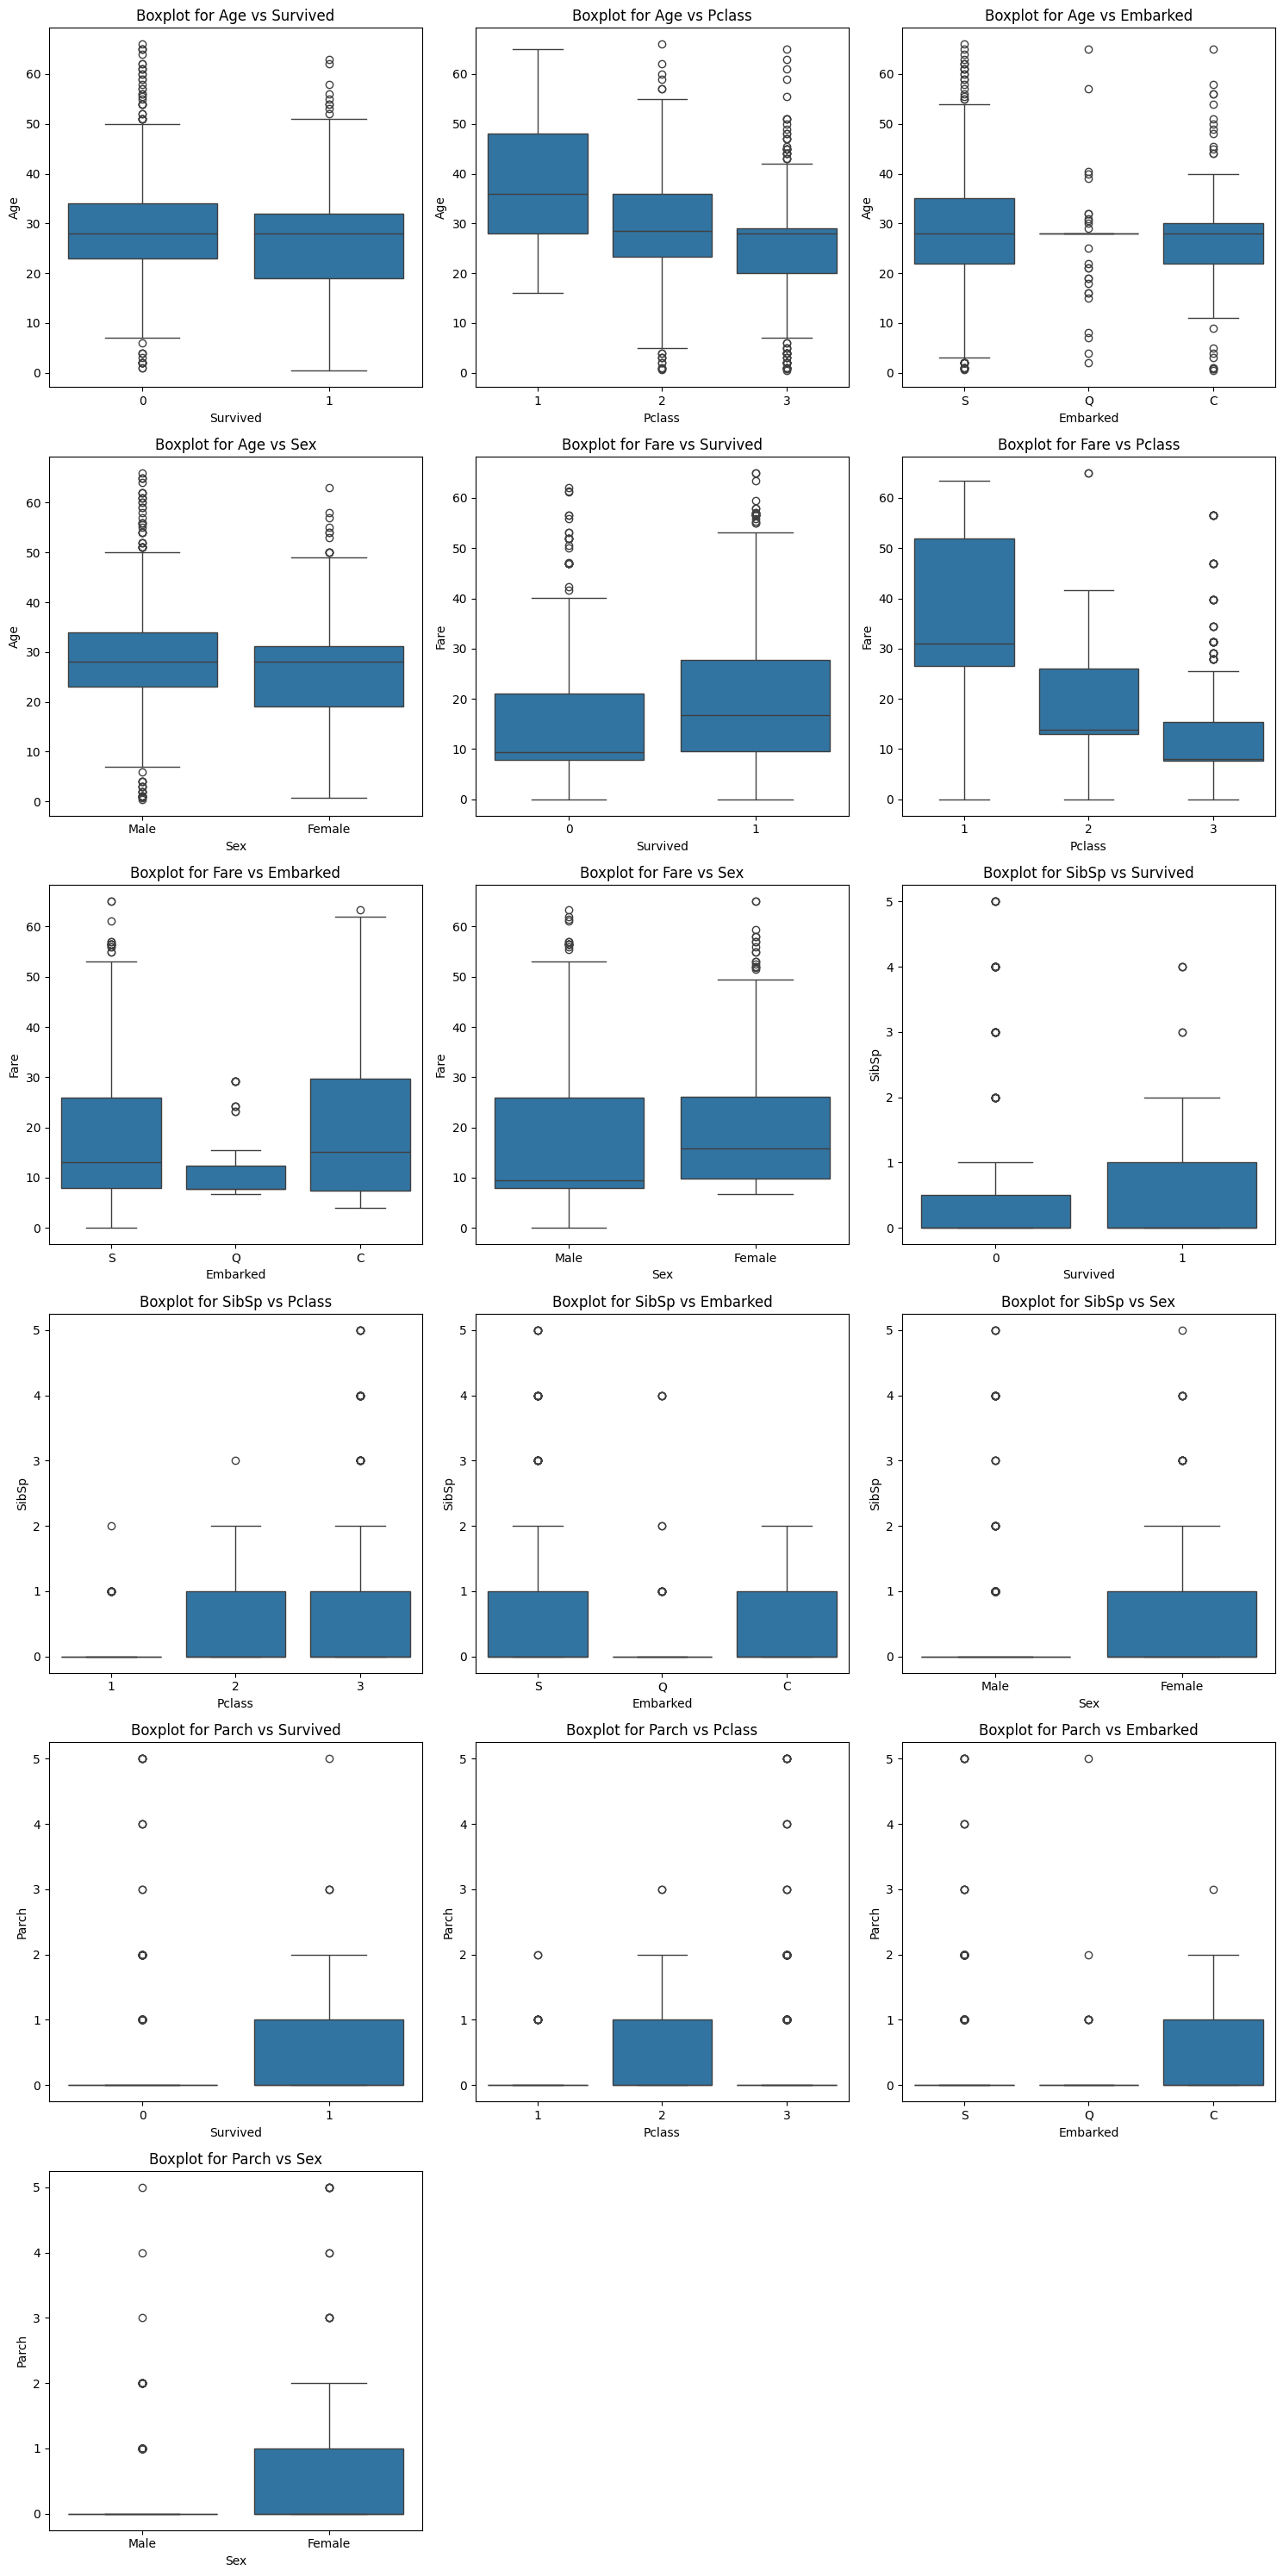

In [22]:
num_pairs = len(numerical_cols) * len(Categorical_Columns)  # Total boxplots
rows = (num_pairs + 2) // 3  # Adjust rows for better layout

fig, axes = plt.subplots(rows, 3, figsize=(15, 5 * rows))  # 3 columns per row
axes = axes.flatten()  # Flatten the axes array for easy iteration

plot_idx = 0
for col in numerical_cols:
    for col2 in Categorical_Columns:
        sns.boxplot(x=col2, y=col, data=df, ax=axes[plot_idx])
        axes[plot_idx].set_title(f"Boxplot for {col} vs {col2}")
        plot_idx += 1

# Hide any unused subplots
for k in range(plot_idx, len(axes)):
    fig.delaxes(axes[k])

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

**Violin Plot**


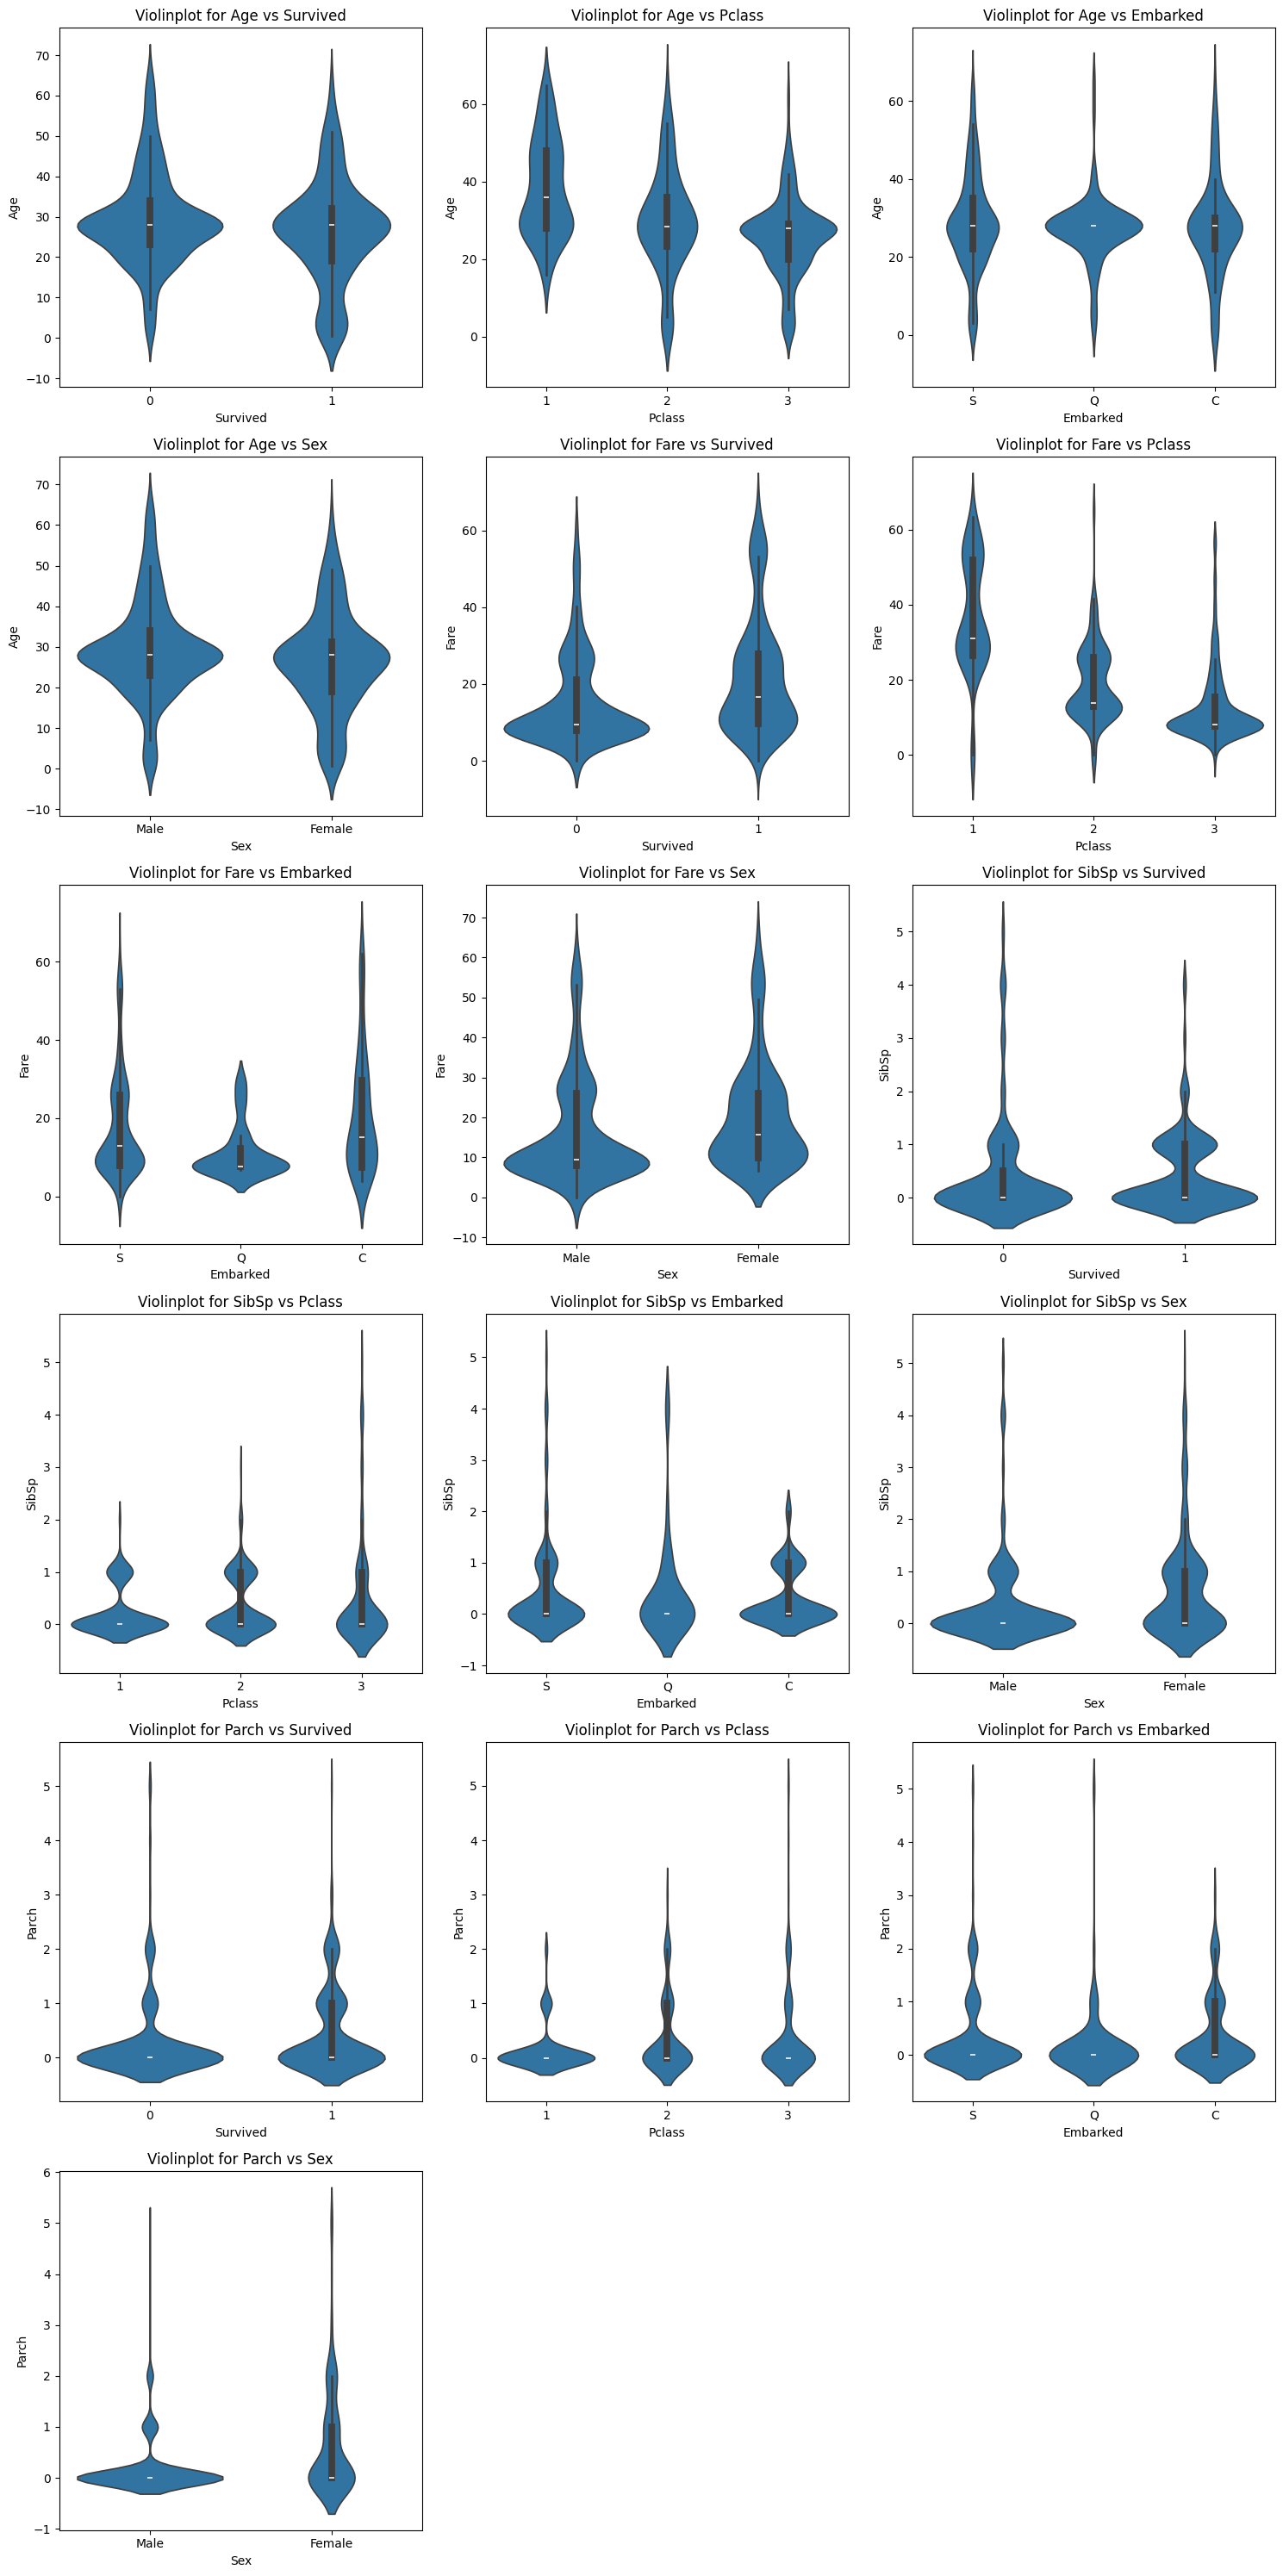

In [23]:
num_pairs = len(numerical_cols) * len(Categorical_Columns)  # Total violin plots
rows = (num_pairs + 2) // 3  # Adjust rows for better layout

fig, axes = plt.subplots(rows, 3, figsize=(15, 5 * rows))  # 3 columns per row
axes = axes.flatten()  # Flatten the axes array for easy iteration

plot_idx = 0
for col in numerical_cols:
    for col2 in Categorical_Columns:
        sns.violinplot(x=col2, y=col, data=df, ax=axes[plot_idx])
        axes[plot_idx].set_title(f"Violinplot for {col} vs {col2}")
        plot_idx += 1

# Hide any unused subplots
for k in range(plot_idx, len(axes)):
    fig.delaxes(axes[k])

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

**KDE-Plot for Survived V/S Age**
 

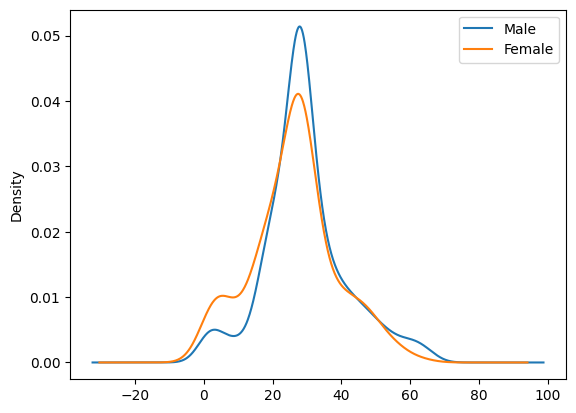

In [25]:
# survived and age

df[df['Sex'] == 'Male']['Age'].plot(kind='kde',label='Male')
df[df['Sex'] == 'Female']['Age'].plot(kind='kde',label='Female')

plt.legend()
plt.show()
        

**Inferences From doing Numerical V/S Categorical Bivariate Analysis**

**Age vs. Survived**
- Survivors had a lower median age, suggesting younger passengers had better survival rates.
- Older passengers had a slightly lower survival rate.
- Infants (Age ~ 0-5) had a higher survival rate, possibly due to priority in evacuation.
---
**Fare vs. Survived**
- Higher fare passengers had a better survival rate, indicating first-class passengers had a survival advantage.
- Lower fare passengers had a higher mortality rate, suggesting economic class played a role.
---
**SibSp/Parch vs. Survived**
- Passengers with 1-3 family members had better survival chances.
- Those traveling alone had lower survival rates.
- Large families (SibSp/Parch > 4) had lower survival rates, possibly due to difficulty in evacuating together.
---
**Age vs. Pclass**
- First-class passengers were older on average.
- Third-class passangers were on the young side.
---
**Fare vs. Pclass**
- **Clear distinction**: First-class fares were significantly higher, while third-class fares were the lowest.
---
**Other Numerical V/S Categorical pairs do not give much inference so they are not included in the analysis but their Plots are still plotted**

**Categorical V/S Categorical**


Pclass     1   2    3
Survived             
0         53  91  363
1         56  87  119




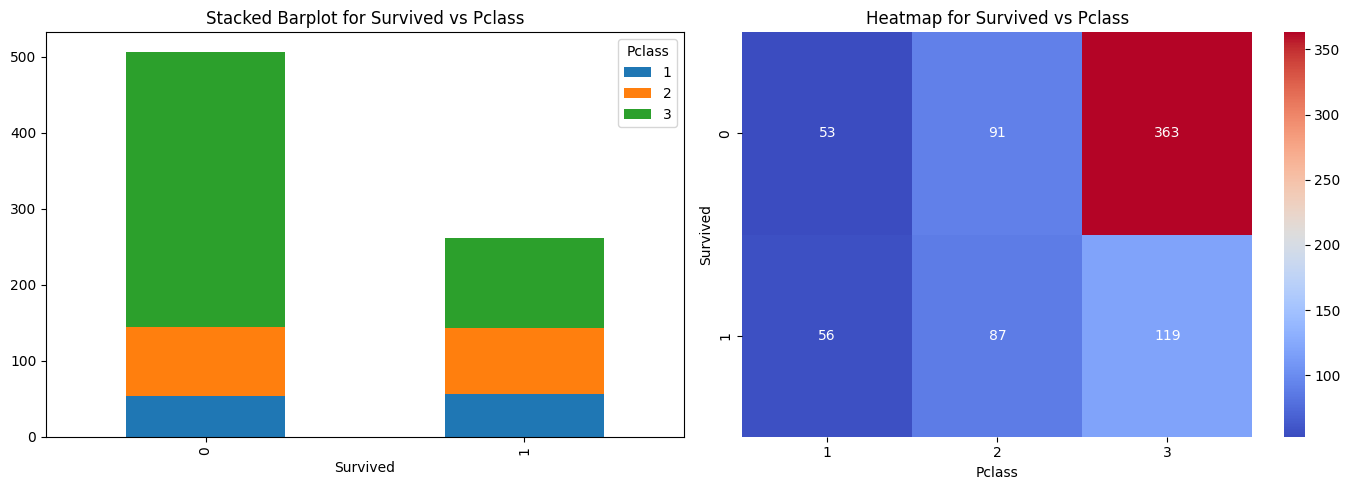

Embarked   C   Q    S
Survived             
0         62  45  400
1         52  29  181




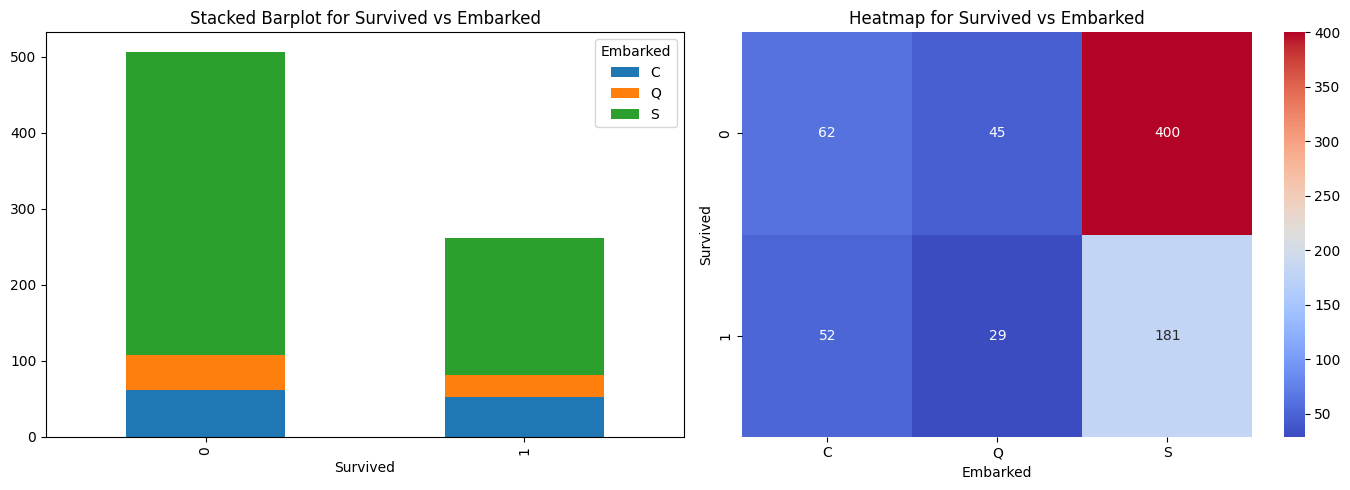

Sex       female  male
Survived              
0             76   431
1            168    94




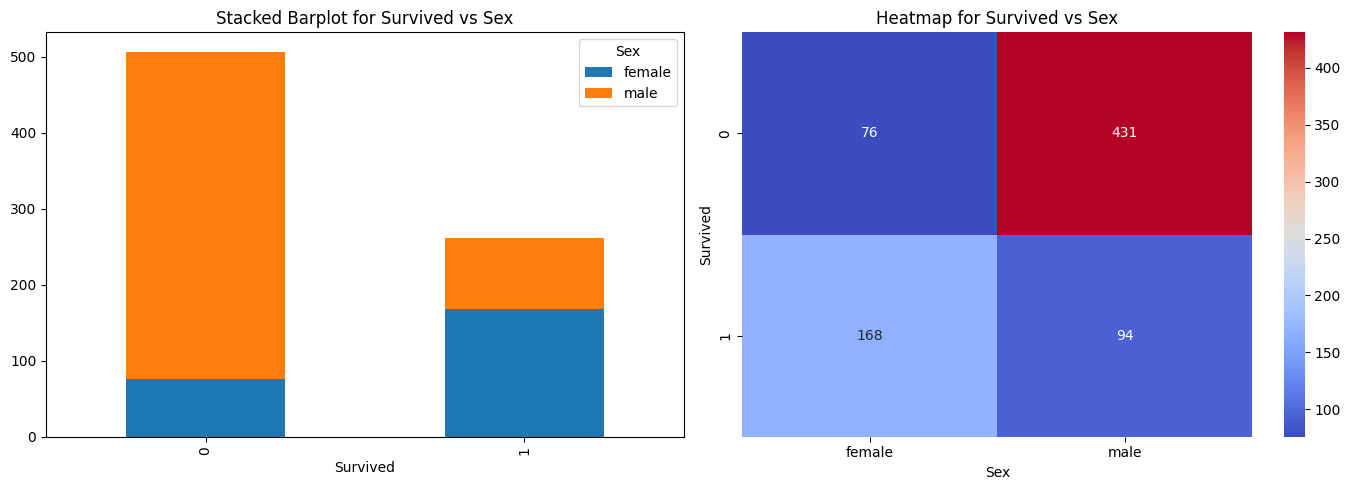

Embarked   C   Q    S
Pclass               
1         31   0   78
2         17   3  158
3         66  71  345




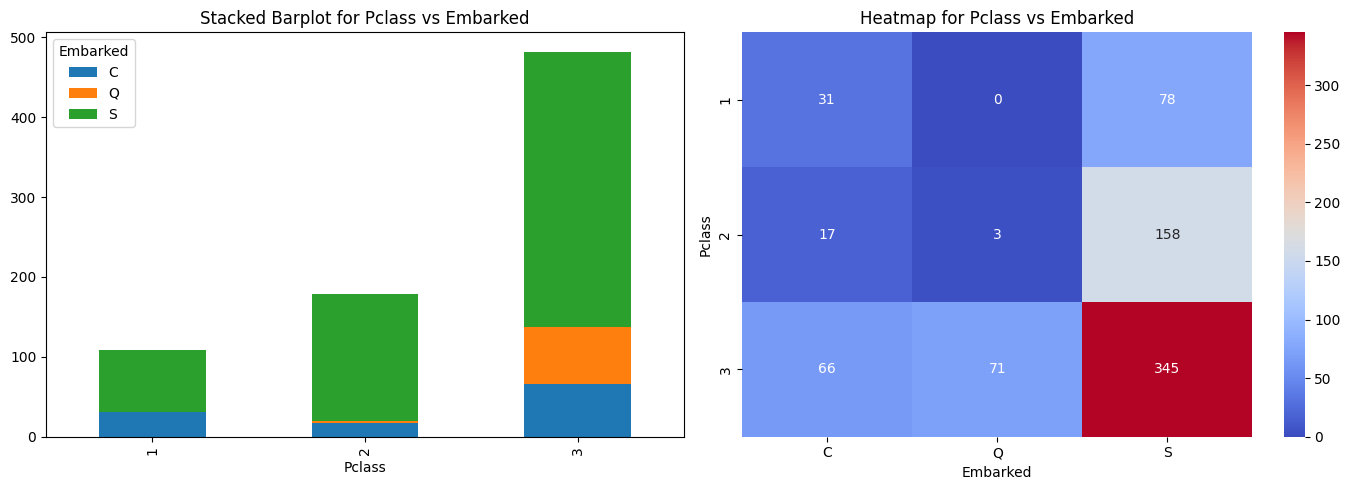

Sex     female  male
Pclass              
1           27    82
2           76   102
3          141   341




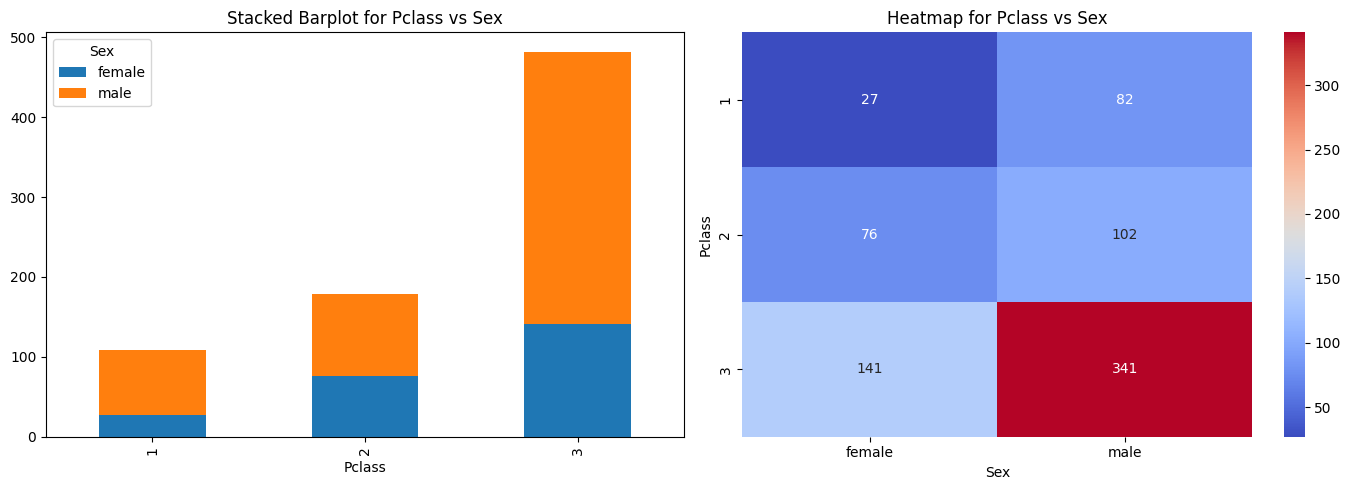

Sex       female  male
Embarked              
C             40    74
Q             35    39
S            169   412




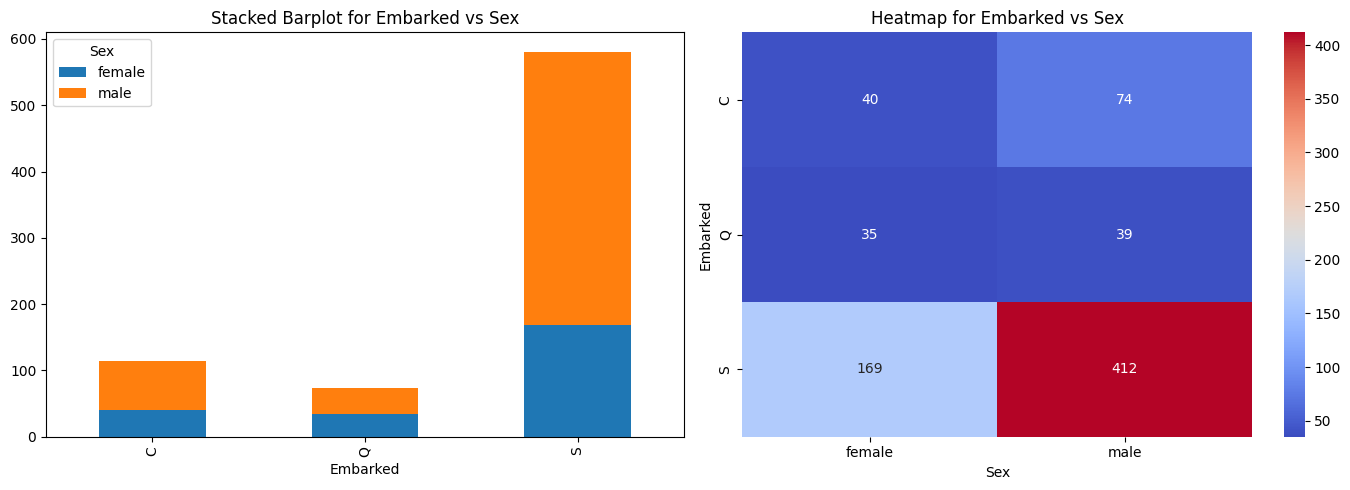

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

for i in range(len(Categorical_Columns)):
    for j in range(i + 1, len(Categorical_Columns)):
        ctab = pd.crosstab(df[Categorical_Columns[i]], df[Categorical_Columns[j]])
        print(ctab)
        print("\n")

        # Create subplots (1 row, 2 columns)
        fig, axes = plt.subplots(1, 2, figsize=(14, 5))

        # Stacked Bar Plot
        ctab.plot(kind="bar", stacked=True, ax=axes[0])
        axes[0].set_title(f"Stacked Barplot for {Categorical_Columns[i]} vs {Categorical_Columns[j]}")

        # Heatmap
        sns.heatmap(ctab, cmap="coolwarm", annot=True, fmt="d", ax=axes[1])
        axes[1].set_title(f"Heatmap for {Categorical_Columns[i]} vs {Categorical_Columns[j]}")

        plt.tight_layout()  # Adjust layout to prevent overlap
        plt.show()

        

**Inferences From doing Categorical V/S Categorical Bivariate Analysis**

**Survived vs. Pclass**
- First-class passengers had the highest survival rate.
- Third-class passengers had the lowest survival rate.
- Indicates that Passenger class played a significant role in survival chances.

**Survived vs. Sex**
- Females had a significantly higher survival rate than males.
- Suggests that probably the **"Women and Children First"** policy was followed.

**Survived vs. Embarked**
- Passengers from Cherbourg had a higher survival rate, likely due to more first-class passengers.
- Passengers from Southampton had a lower survival rate, indicating more third-class passengers.

**Pclass vs. Embarked**
- Most first-class passengers embarked from Cherbourg, while third-class passengers were mainly from Southampton.
- Suggests economic disparities between embarkation points.

### **Key Insights from Doing Bivariate Analysis**
- **Survival rate** was highly dependent on class, gender, and fare price.
- Childrens and those with small families had better survival chances.
- Higher-class passengers had significantly higher fares and survival rates.
- Women had better survival rates compared to men across all classes.
- Embarkation location had some influence, likely due to class distribution.

These insights help us understand how different features influenced survival rates on the Titanic.

## **3. Multivariate Analysis**

#### **Pair Plots with Respect to Different Categorical Columns**

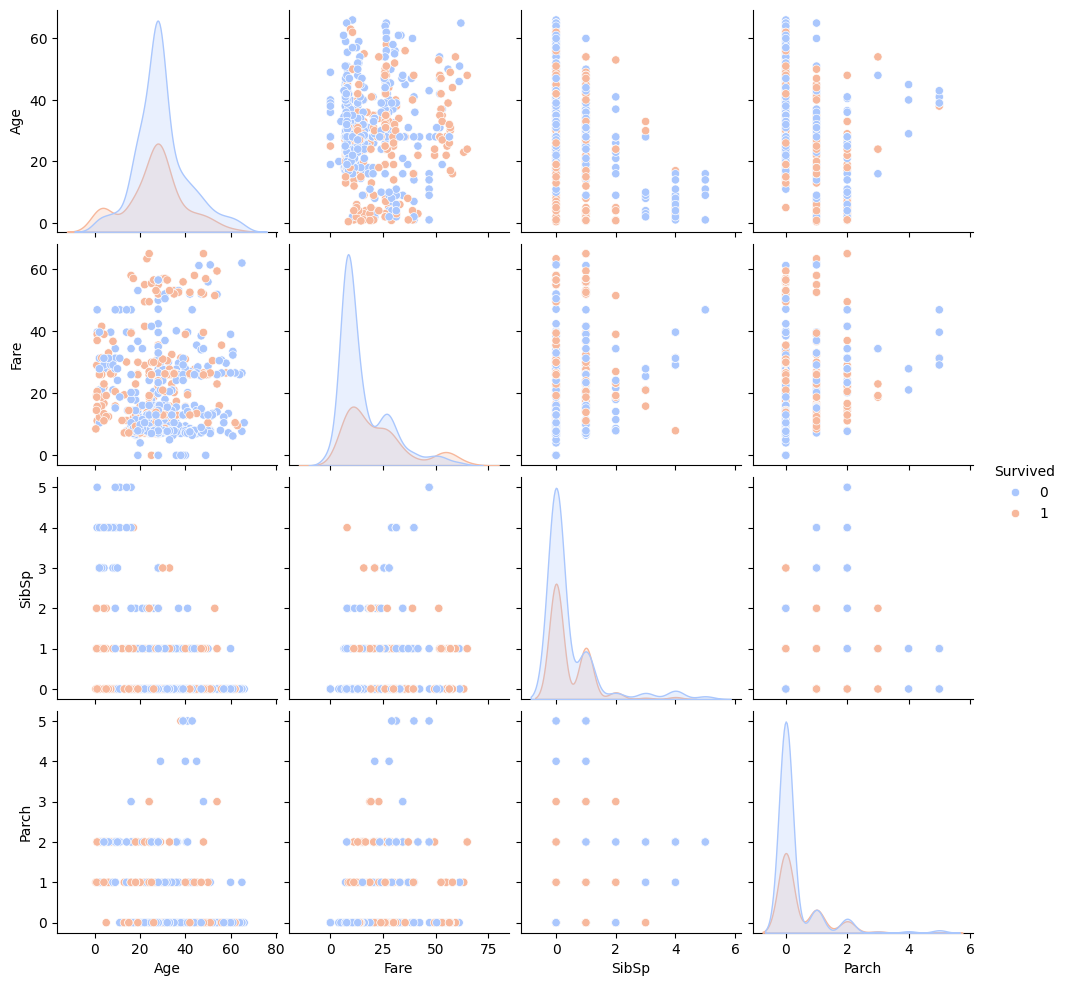

In [ ]:
sns.pairplot(df,vars=numerical_cols,hue="Survived",palette="coolwarm")
plt.show()


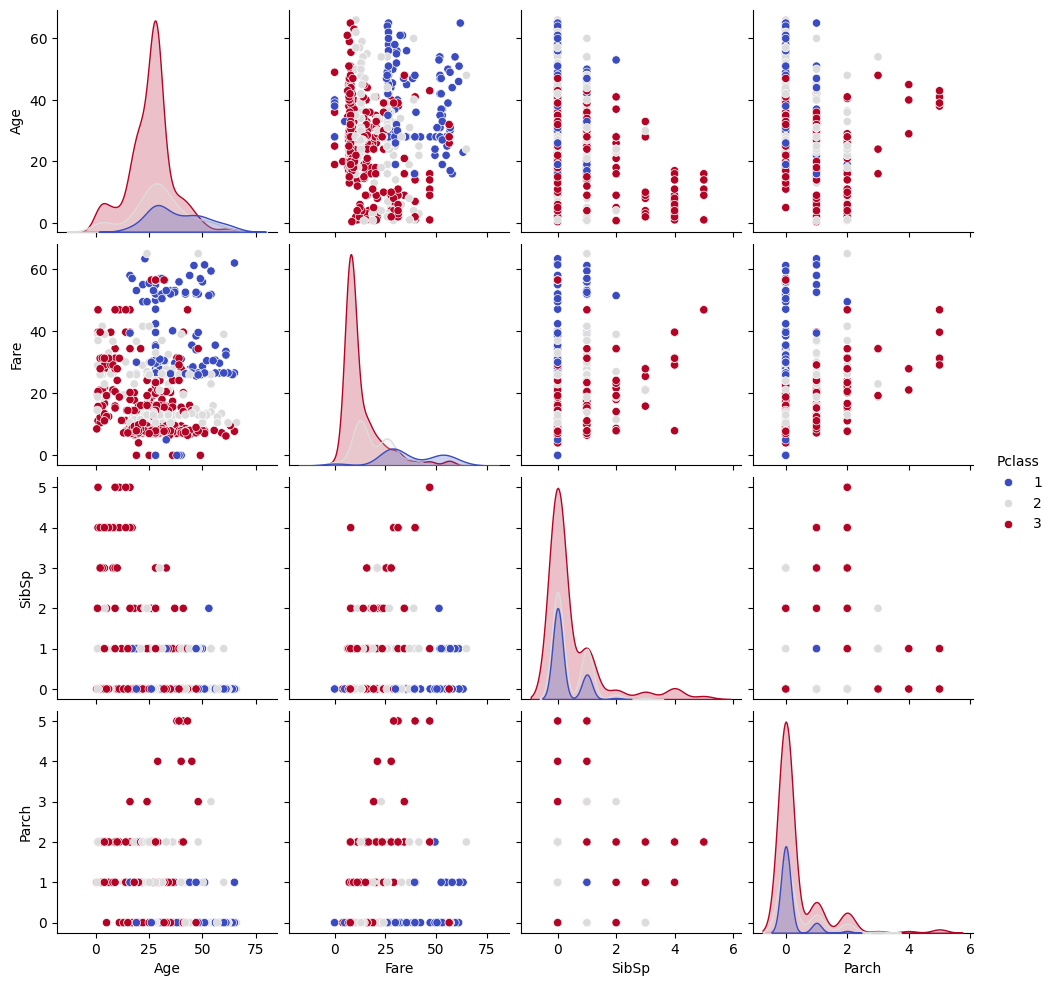

In [ ]:
sns.pairplot(df,vars=numerical_cols,hue="Pclass",palette="coolwarm")
plt.show()


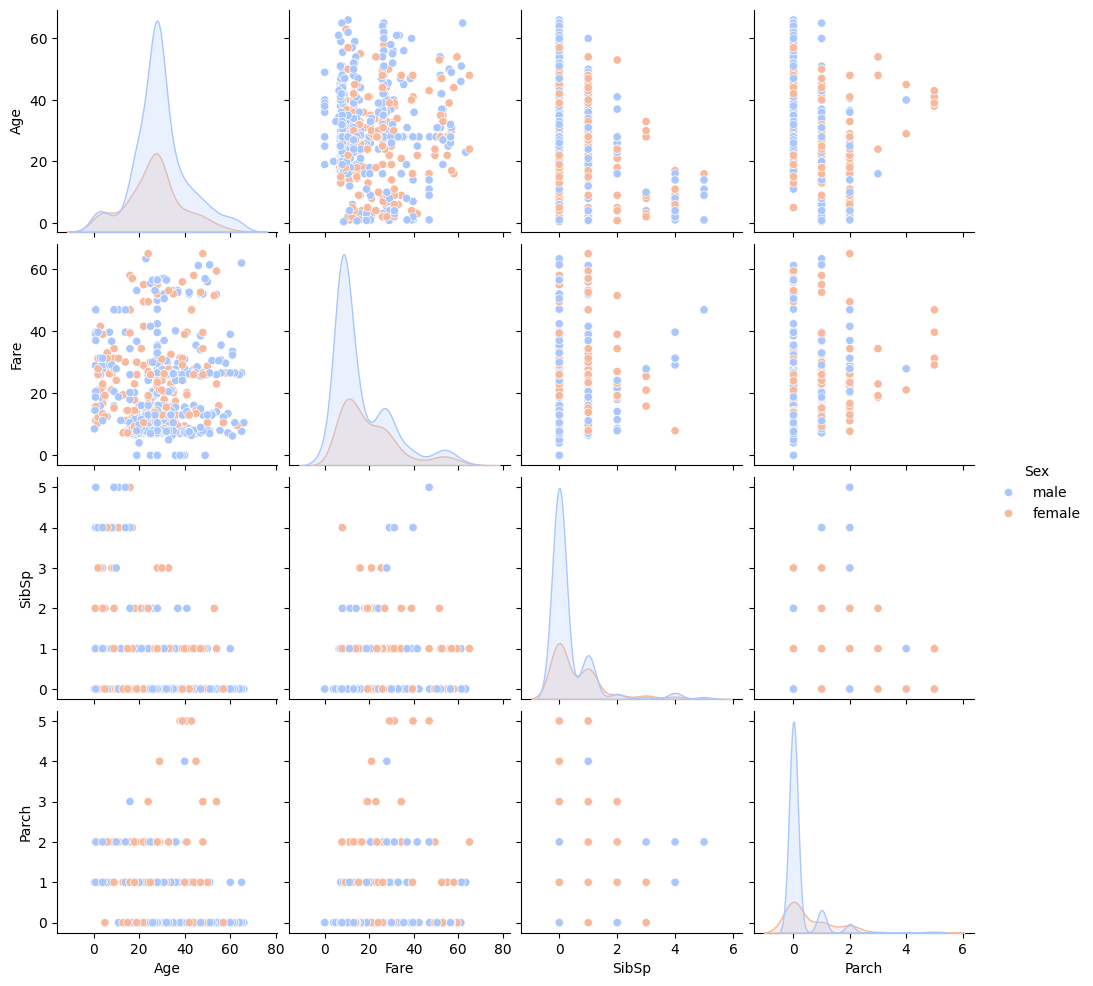

In [ ]:
sns.pairplot(df,vars=numerical_cols,hue="Sex",palette="coolwarm")
plt.show()

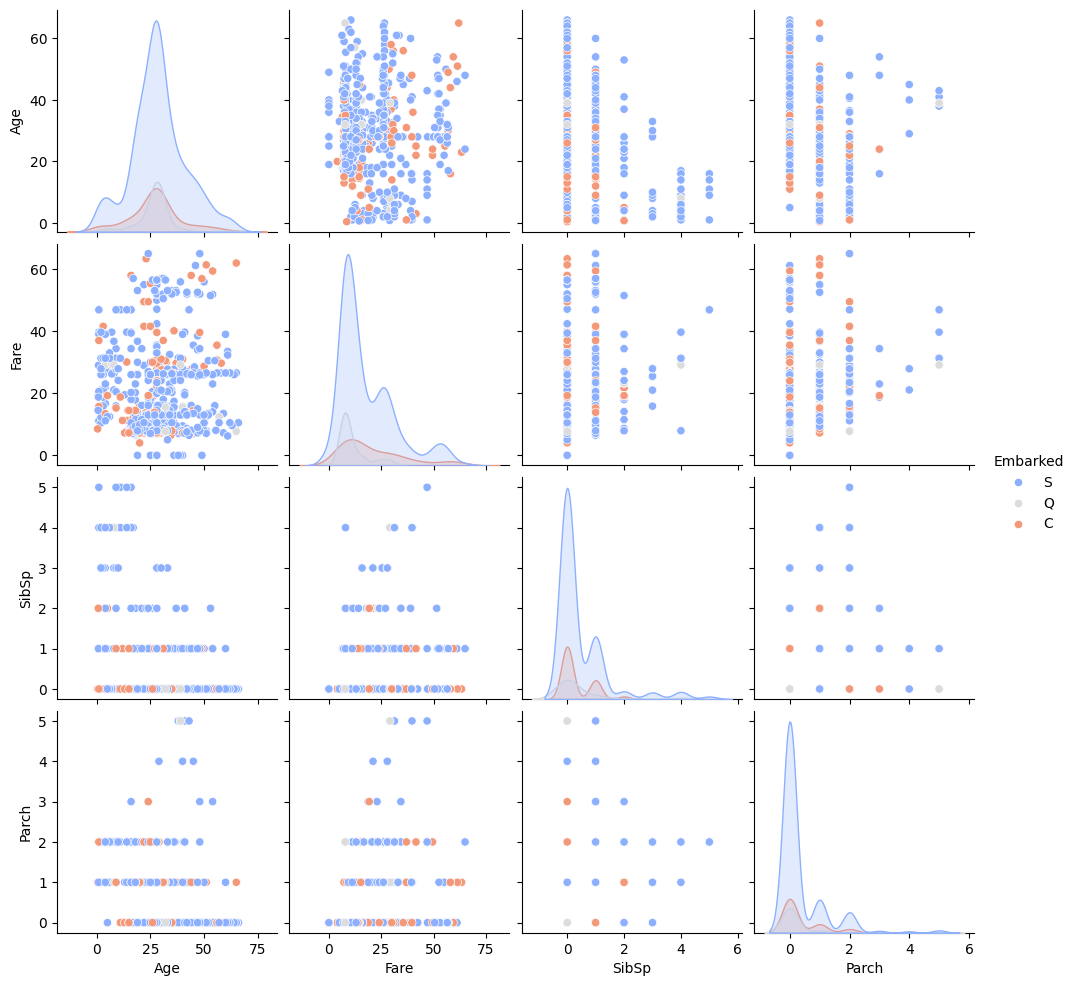

In [ ]:
sns.pairplot(df,vars=numerical_cols,hue="Embarked",palette="coolwarm")
plt.show()

### **Combined Insights from Pair Plots**  

**Survival Patterns**  
- Passengers who paid higher fares had a better chance of survival.  
- Childrens showed slightly higher survival rates.  
---
**Impact of Passenger Class**  
- First-class travelers were generally older and paid more for tickets.  
- Third-class passengers tended to be younger with lower fares. 
- The difference between passengers in different classes is very low for first and second class but is very high for first and second compared with third class. 
---
**Gender-Based Trends**  
- Women had a significantly higher survival rate and were often in higher fare categories.  
- Men displayed a broader age distribution and were more common in lower fare brackets.  
---
**Effects of Embarkation Point**  
- Passengers boarding from Cherbourg  typically paid more, suggesting many were in first class.  
- Southampton  had a larger share of third-class travelers, reflected in lower fares. 
---
**Patterns in Numerical Features**  
- Older passengers were generally associated with higher fare payments. 
- A strong correlation exists between SibSp and Parch, indicating families often traveled together.  


#### **HeatMap**

<Axes: >

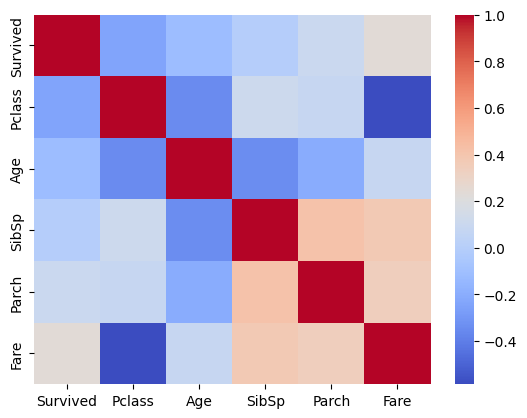

In [ ]:
sns.heatmap(correlation_matrix,cmap='coolwarm')

#### **Heatmap Analysis of Feature Correlations**  

The heatmap illustrates the relationships among key variables like **SibSp, Age, Pclass, Survived, Fare, and Parch**.  

- **Fare and Survived exhibit the strongest positive correlation**, indicating that passengers who paid more had higher survival chances.  
- Pclass has a **negative correlation** with survival, meaning that passengers in lower classes (higher Pclass values) were less likely to survive.  
- Age shows a **weak correlation** with survival, suggesting that age alone was not a strong determinant.  
- SibSp and Parch have **minimal influence** on survival, indicating that family size had little impact.


**Overall, Fare and Pclass emerge as the most significant predictors of survival.**  


#### **Scatterplot**

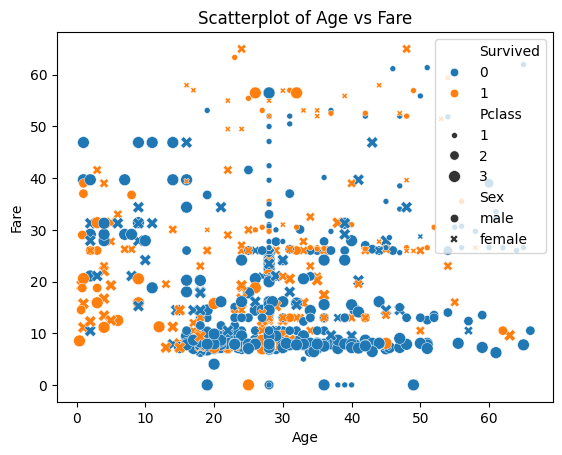

In [ ]:
sns.scatterplot(x = df['Age'], y = df['Fare'], hue = df['Survived'],style = df['Sex'],size = df['Pclass'])
plt.title("Scatterplot of Age vs Fare")
plt.show()

#### **Analysis of Age vs. Fare Scatterplot with Survival, Sex, and Pclass**  

The scatterplot visualizing **Age vs. Fare**, with different scatterplot attributes representing **Survival, Sex, and Pclass**, highlights key patterns:  

- Childrens and those who paid higher fares (mainly Pclass 1) had better survival rates.  
- A noticeable concentration of survivors is seen in the higher fare ranges, reinforcing the impact of economic status.  
- Females dominate among the survivors, particularly those who paid more for their tickets.  
- Passengers in Pclass 3, who typically paid the least, exhibit a lower probability of survival. 

**Overall, survival is influenced by a combination of age, fare, gender, and class.**


#### **Barplot**

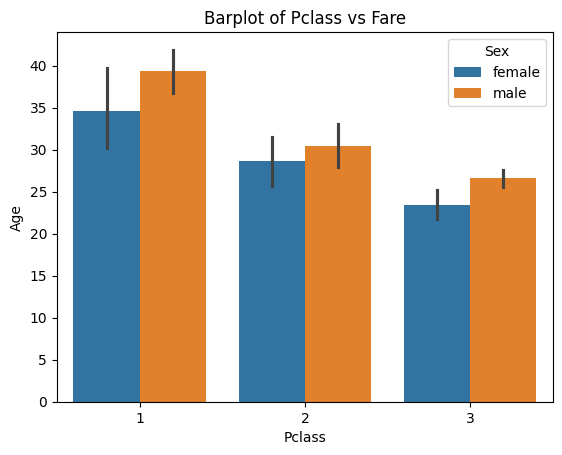

In [ ]:
sns.barplot(x = df['Pclass'], y = df['Age'], hue = df['Sex'])
plt.title("Barplot of Pclass vs Age")
plt.show()

#### **Insights from the Barplot of Pclass vs. Age (Grouped by Sex)**  

- Passengers in higher classes (Pclass 1) tend to be older compared to those in lower classes (Pclass 3).  
- Males have a slightly higher average age across all classes compared to females. 
- The difference in age between males and females is most noticeable in first-class, where males appear to be significantly older on average.  
- The age distribution decreases gradually from Pclass 1 to Pclass 3, indicating that younger individuals were more likely to travel in lower classes. 


#### **Boxplot**

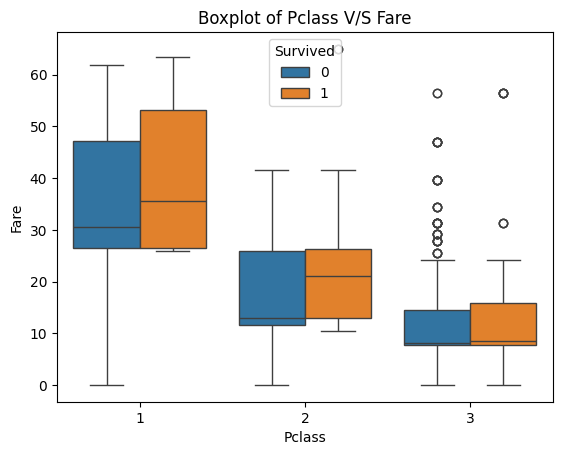

In [ ]:
sns.boxplot(x = df['Pclass'], y = df['Fare'], hue = df['Survived'])
plt.title("Boxplot of Pclass V/S Fare")
plt.show()

#### **Insights from the Boxplot of Pclass vs. Fare (Grouped by Survival Status)**  

- Passengers in first class (Pclass 1) paid **significantly higher** fares on average compared to those in second (Pclass 2) and third class (Pclass 3). 
- Survivors generally had higher fares across all classes, especially in Pclass 1 and Pclass 2.  
- In Pclass 1, the median fare for survivors is noticeably higher than for non-survivors, indicating that passengers who paid more had a better chance of survival. 
- Pclass 3 shows a large number of outliers in fare, suggesting that while most third-class passengers paid lower fares, a few paid significantly more.  
- The **Interquartile Range (IQR)** for fares is wider in first class, showing more variation in fare prices compared to second and third class. 
- Survival in lower classes (Pclass 2 and Pclass 3) is more evenly distributed in terms of fare, though survivors still tend to have slightly higher fares. 


#### **Histplot**

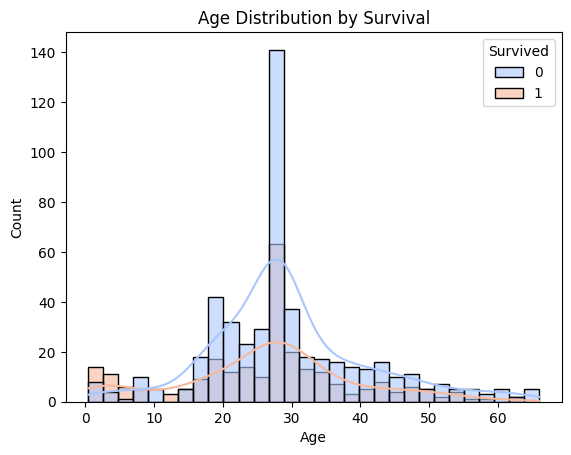

In [ ]:
sns.histplot(data=df, x="Age", hue="Survived", kde=True, bins=30, palette="coolwarm", alpha=0.6)
plt.title("Age Distribution by Survival")
plt.xlabel("Age")
plt.ylabel("Count")
plt.show()

#### **Insights from the Age Distribution by Survival**  

- Most passengers were between the ages of **20 and 40**, with a peak around **30 years old.**  
- The number of non-survivors is consistently higher than survivors across most age groups.  
- **Children (ages 0-10)** had a higher survival rate compared to other age groups, suggesting they were prioritized during rescue efforts. 
- **Young adults (ages 20-40)** had the highest number of non-survivors, indicating that this group faced a higher risk. 
- **Older passengers (above 50)** were fewer in number, with a relatively balanced survival distribution.  
- The survival rate among infants and young children appears notably higher compared to other age groups.
